## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [ ]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import library to save in pickle format
import pickle

# import python librairy
import scipy.stats as stats

# to know if variable is skewed or not
from scipy.stats import skew

# to divide train and test set, gridsearch and cross_validation
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# to dertermine the optimal training size
from sklearn.model_selection import learning_curve

# feature scaling
from sklearn.preprocessing import StandardScaler, Binarizer

# to build the models
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

# ========== NEW IMPORTS ========
# Respect to notebook 02-Predicting-Survival-Titanic-Solution

# pipeline
from sklearn.pipeline import Pipeline

# this way is only for google colabs
# for the house preprocessors : house transformers we create for our self
import sys
import os
path_m = '/content/preprocessors/'
sys.path.insert(0,path_m)
import house_preprocessors as h_pp

# from feature-engine
!pip install feature_engine
# for imputation missing categorical variables with string missing and frequent values
from feature_engine.imputation import CategoricalImputer

# for adding missing indicator for missing numerical variable
from feature_engine.imputation import AddMissingIndicator

# for imputation numerical variables with the mean or median or ...
from feature_engine.imputation import MeanMedianImputer

# for droping features
from feature_engine.selection import DropFeatures

# for variable transformation
from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

# for features binarization
from feature_engine.wrappers import SklearnTransformerWrapper


# for encoding Rare labels and categorical variables
from feature_engine.encoding import (
    RareLabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
)

# Conclusion

This is the begenning of our project.

The steps we will pass trough are:

- Preparation of data set
- Analysis and exploration of data set
- Feature engeneering without pipeline method
- Feature engeneering with pipeline method
- Feature Selection
- Model Building

## **DATA SET PREPARATION**

In [ ]:
# load the data - it is available open source and online

data0 = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data0.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [ ]:
# make a copy of data set
data = data0.copy()

In [ ]:
# get information about columns in dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1309 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1309 non-null   object
 9   cabin      1309 non-null   object
 10  embarked   1309 non-null   object
 11  boat       1309 non-null   object
 12  body       1309 non-null   object
 13  home.dest  1309 non-null   object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB
None


*Conclusion: variable age and fare are numerical instead object. So we need to fix it after fill the missing values in the data set*

In [ ]:
# check that we have missing values in the variables

#list of string we want to check the presence
missing_values_list = ['N/A', 'na', 'NaN', 'none', 'null', '-', '#N/A', 'n/a', 'NA', 'n/a', 'n.a.', 'undefined', 'unknown', 'missing', '?', '...']  # Add more if needed
data.isin(missing_values_list).sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [ ]:
# check the variables of data set does contain missing values

#list of string we want to check the presence
missing_values_list = ['N/A', 'na', 'NaN', 'none', 'null', '-', '#N/A', 'n/a', 'NA', 'n/a', 'n.a.', 'undefined', 'unknown', 'missing', '?', '...']  # Add more if needed
[var for var in data.columns if data[var].isin(missing_values_list).sum() > 0]

['age', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']

In [ ]:
# List of common representations of missing values
missing_values_list = ['N/A', 'na', 'NaN', 'none', 'null', '-', '#N/A', 'n/a', 'NA', 'n/a', 'n.a.', 'undefined', 'unknown', 'missing', '?', '...']  # Add more if needed

# replace interrogation marks by NaN values
for mis_val in missing_values_list:
  data = data.replace(mis_val, np.nan)

In [ ]:
# check if missing values are abscent in the data set

#list of string we want to check the presence
missing_values_list = ['N/A', 'na', 'NaN', 'none', 'null', '-', '#N/A', 'n/a', 'NA', 'n/a', 'n.a.', 'undefined', 'unknown', 'missing', '?', '...']  # Add more if needed
data.isin(missing_values_list).sum()

pclass       0
survived     0
name         0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
cabin        0
embarked     0
boat         0
body         0
home.dest    0
dtype: int64

In [ ]:
# check if ther is no variables witch contain missing values

#list of string we want to check the presence
missing_values_list = ['N/A', 'na', 'NaN', 'none', 'null', '-', '#N/A', 'n/a', 'NA', 'n/a', 'n.a.', 'undefined', 'unknown', 'missing', '?', '...']  # Add more if needed
[var for var in data.columns if data[var].isin(missing_values_list).sum() > 0]

[]

*Conclusion: all missing value is replaced by nan*

In [ ]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [ ]:
# get information about columns in dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    object 
 13  home.dest  745 non-null    object 
dtypes: float64(2), int64(4), object(8)
memory usage: 143.3+ KB
None


*Conclusion: variable age and fare are very well converted into numerical type*

In [ ]:
# display cabin data
data['cabin'].head()

0         B5
1    C22 C26
2    C22 C26
3    C22 C26
4    C22 C26
Name: cabin, dtype: object

In [ ]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan

data['cabin'] = data['cabin'].apply(get_first_cabin)

In [ ]:
# check that cabin data are split very well

# display cabin data
data['cabin'].head()

0     B5
1    C22
2    C22
3    C22
4    C22
Name: cabin, dtype: object

*Conclusion: Variable 'cabin' data have first split data*

In [ ]:
# display name data
data['name'].head()

0                      Allen, Miss. Elisabeth Walton
1                     Allison, Master. Hudson Trevor
2                       Allison, Miss. Helen Loraine
3               Allison, Mr. Hudson Joshua Creighton
4    Allison, Mrs. Hudson J C (Bessie Waldo Daniels)
Name: name, dtype: object

In [ ]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'

data['title'] = data['name'].apply(get_title)

In [ ]:
# check that title data are very well extracted

# display cabin data
data['title'].head()

0      Miss
1    Master
2      Miss
3        Mr
4       Mrs
Name: title, dtype: object

*Conclusion: Title columns is created in the data set*

In [ ]:
# drop unnecessary variables
drop_values_list = ['name','ticket', 'boat', 'body','home.dest']
data.drop(labels=drop_values_list, axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [ ]:
# check that we don't have unnecessary variables in the data set

#list of string we want to check the presence
drop_values_list = ['name','ticket', 'boat', 'body','home.dest']  # Add more if needed
data.columns.isin(drop_values_list).sum()

0

In [ ]:
# check the presence of unnecessary variables in the data set

#list of string we want to check the presence
drop_values_list = ['name','ticket', 'boat', 'body','home.dest']  # Add more if needed
[var for var in data.columns if data[var].isin(drop_values_list).sum() > 0]

[]

*Conclusion: all unnecessary variables is droped*

In [ ]:
# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [ ]:
# get information about columns in dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   cabin     295 non-null    object 
 8   embarked  1307 non-null   object 
 9   title     1309 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 102.4+ KB
None



**Saving data after dataset preparation**

In [ ]:
# save data for data analysis and exploration
data.to_csv('titanic_DataPrep.csv', index=False)

# Conclusion

Now we finish Preparation step of our data set.

The next steps are:

- Analysis and exploration of data set
- Feature engeneering without pipeline method
- Feature engeneering with pipeline method
- Feature Selection
- Model Building

## **DATA SET ANALYSIS AND EXPLORATION**


The titanic dataset contains 1309 rows, that is, houses, and 10 columns, i.e., variables.

9 are predictive variables and 1 is the target variable: survived

**Analysis**

**We will analyse the following:**

1. The target variable
2. Variable types (categorical and numerical)
3. Missing data
4. Numerical variables
    - Temporal variables
    - Discrete
    - Continuous
    - Distributions (Gaussian or Skewed)
    - Transformations
    - Outliers

5. Categorical variables
    - Cardinality
    - Quality variables and mappings
    - Special mappings
    - Rare Labels
    
6. Additional Reading Resources

In [ ]:
# load dataset
data0 = pd.read_csv('/content/sample_data/titanic_DataPrep.csv')

# rows and columns of the data
print(data0.shape)

# visualise the dataset
data0.head()

(1309, 10)


,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [ ]:
# copy the data set
data=data0.copy()

**The target variable**

Let's begin by exploring the target distribution.

Because it's classification problem, we don't have target distribution here

In [ ]:
# assign the target we want to predict
target = 'survived'
data_targ = data['survived']

**Variable types (categorical and numerical)**

Next, let's identify the categorical and numerical variables

In [ ]:
# now let's identify the numerical variables
vars_num = [var for var in data.columns if data[var].dtype != 'O' and var != target]

# we will capture those of type *object*
vars_cat = [var for var in data.columns if var not in vars_num and var != target]

# we will capture those of type *object*
#vars_cat = [var for var in data.columns if data[var].dtype == 'O']

# now let's identify the numerical variables
#vars_num = [var for var in data.columns if var not in vars_cat and var != target]

# print the number of numerical and categorical variables
print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


**Save the categorical and numerical list variable**

In [ ]:
# Create a list
NUMERICAL_VARIABLES = vars_num
CATEGORICAL_VARIABLES = vars_cat

# Specify the file name to save the list to
NUMERICAL_VARIABLES_file_name = 'NUMERICAL_VARIABLES.pkl'
CATEGORICAL_VARIABLES_file_name = 'CATEGORICAL_VARIABLES.pkl'


# Save the list to a file using pickle
with open(NUMERICAL_VARIABLES_file_name, 'wb') as file:
    pickle.dump(NUMERICAL_VARIABLES, file)

# Save the list to a file using pickle
with open(CATEGORICAL_VARIABLES_file_name, 'wb') as file:
    pickle.dump(CATEGORICAL_VARIABLES, file)

**Find missing values in variables**

All variables

In [ ]:
# make a list of the variables that contain missing values
vars_with_nan = [var for var in data.columns if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[vars_with_nan].isnull().mean().sort_values(ascending=False)

cabin       0.774637
age         0.200917
embarked    0.001528
fare        0.000764
dtype: float64

Numerical variables

In [ ]:
# first in numerical variables

# make a list of the variables that contain missing values
vars_num_with_nan = [var for var in vars_num if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data
data[vars_num_with_nan].isnull().mean().sort_values(ascending=False)

age     0.200917
fare    0.000764
dtype: float64

*Conclusion: Our dataset contains one variable with mean proportion of missing values (one variables at the top). And the other variable with a small percentage of missing observations (last variable).*

*This means that to train a machine learning model with this data set, we need to impute (or have a treatment of) the missing data in these variables.*

*We can also visualize the percentage of missing values in the variables as follows:*

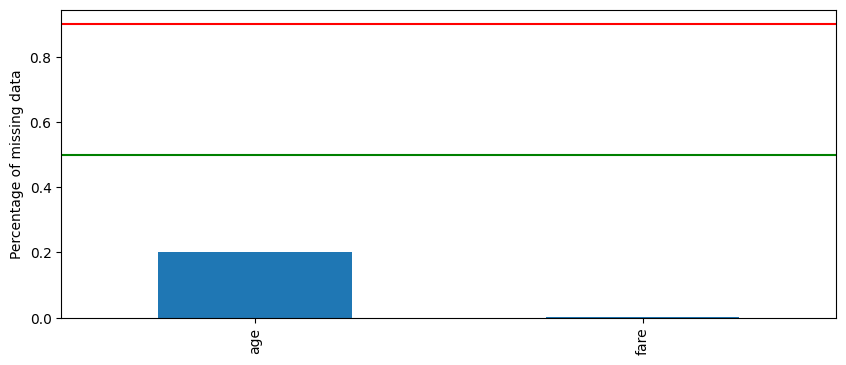

In [ ]:
# plot
data[vars_num_with_nan].isnull().mean().sort_values(
    ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel('Percentage of missing data')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.axhline(y=0.50, color='g', linestyle='-')

plt.show()

Categorical variables

In [ ]:
# now in categorical variables

# make a list of the variables that contain missing values
vars_cat_with_nan = [var for var in vars_cat if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data
data[vars_cat_with_nan].isnull().mean().sort_values(ascending=False)

cabin       0.774637
embarked    0.001528
dtype: float64

*Conclusion: Our dataset contains one variable with a big proportion of missing values (one variables at the top). And the other variable with a small percentage of missing observations (last variable).*

*This means that to train a machine learning model with this data set, we need to impute (or have a treatment of) the missing data in these variables.*

*We can also visualize the percentage of missing values in the variables as follows:*

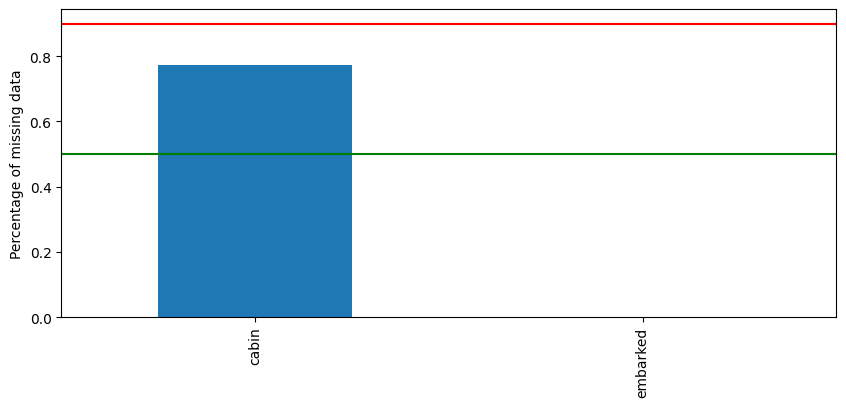

In [ ]:
# plot
data[vars_cat_with_nan].isnull().mean().sort_values(
    ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel('Percentage of missing data')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.axhline(y=0.50, color='g', linestyle='-')

plt.show()

**Treatment of missing value for categorical variable**

To engineer missing values in categorical variables, we will:

- We will replace missing values with the string "missing" in those variables with a lot of missing data
- Alternatively, we will replace missing data with the most frequent category in those variables that contain fewer observations without values

This is common practice.

In [ ]:
# categorical variables to impute with the string missing
vars_cat_nan_with_string_missing = [
    var for var in vars_cat_with_nan if data[var].isnull().mean() > 0.1]

# categorical variables to impute with the most frequent category
vars_cat_nan_with_frequent_category = [
    var for var in vars_cat_with_nan if data[var].isnull().mean() < 0.1]

In [ ]:
vars_cat_nan_with_string_missing

['cabin']

In [ ]:
vars_cat_nan_with_frequent_category

['embarked']

Relationship between missing data and survived

In [ ]:
def analyse_na_value(df, var, target):

    # copy of the dataframe, so that we do not override the original data
    # see the link for more details about pandas.copy()
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html
    df = df.copy()

    # let's make an interim variable that indicates 1 if the
    # observation was missing or 0 otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    # let's compare the median SalePrice in the observations where data is missing
    # vs the observations where data is available

    # determine the median price in the groups 1 and 0,
    # and the standard deviation of the sale price,
    # and we capture the results in a temporary dataset
    tmp = df.groupby(var)[target].agg(['mean', 'std'])

    # plot into a bar graph
    tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title=target, color='green')

    plt.show()

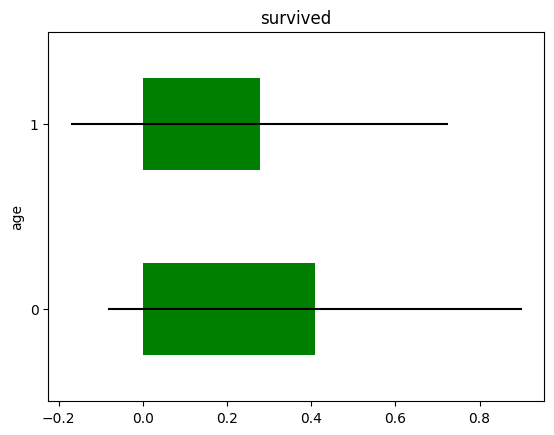

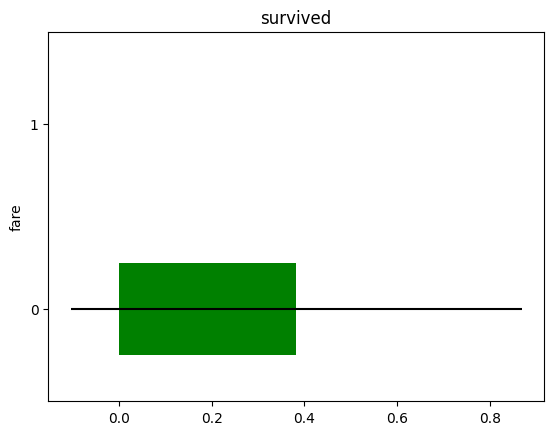

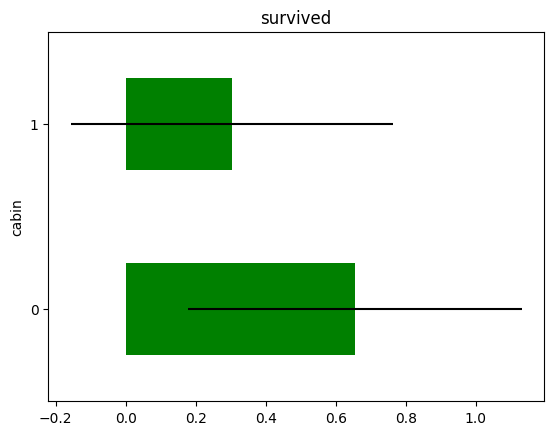

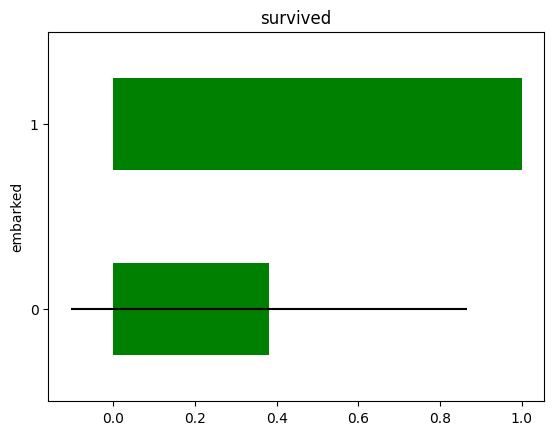

In [ ]:
# let's run the function on each variable with missing data

for var in vars_with_nan:
    analyse_na_value(data, var, target)

**Save the missing categorical and numerical list variable**

In [ ]:
# Create a list
NUMERICAL_VARIABLES_WITH_NAN = vars_num_with_nan
CATEGORICAL_VARIABLES_WITH_NAN = vars_cat_with_nan
CATEGORICAL_VARIABLES_WITH_NAN_MISSING = vars_cat_nan_with_string_missing
CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT = vars_cat_nan_with_frequent_category

# Specify the file name to save the list to
NUMERICAL_VARIABLES_WITH_NAN_file_name = 'NUMERICAL_VARIABLES_WITH_NAN.pkl'
CATEGORICAL_VARIABLES_WITH_NAN_file_name = 'CATEGORICAL_VARIABLES_WITH_NAN.pkl'
CATEGORICAL_VARIABLES_WITH_NAN_MISSING_file_name = 'CATEGORICAL_VARIABLES_WITH_NAN_MISSING.pkl'
CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT_file_name = 'CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT.pkl'


# Save the list to a file using pickle
with open(NUMERICAL_VARIABLES_WITH_NAN_file_name, 'wb') as file:
    pickle.dump(NUMERICAL_VARIABLES_WITH_NAN, file)

# Save the list to a file using pickle
with open(CATEGORICAL_VARIABLES_WITH_NAN_file_name, 'wb') as file:
    pickle.dump(CATEGORICAL_VARIABLES_WITH_NAN, file)

# Save the list to a file using pickle
with open(CATEGORICAL_VARIABLES_WITH_NAN_MISSING_file_name, 'wb') as file:
    pickle.dump(CATEGORICAL_VARIABLES_WITH_NAN_MISSING, file)

# Save the list to a file using pickle
with open(CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT_file_name, 'wb') as file:
    pickle.dump(CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT, file)

**Treatment of other numerical variables**

*   Temporal variables
*   Discrete variables


*   Continuous variables
*   Distributions (Gaussian or Skewed)


*   Transformations
*   Outliers

**Determine the temporal variables**

In [ ]:
# list of temporal variables
temp_num_vars = []

*Conclusion: there is no temporal variable in data set*

**Determine the discrete variables**

Let's go ahead and find which variables are discrete, i.e., show a finite number of values

In [ ]:
# let's male a list of discrete variables
discrete_vars_num = [var for var in vars_num if len(data[var].unique()) < 20 and var not in temp_num_vars]
# print the number of discrete variables
print('Number of discrete variables: ', len(discrete_vars_num))

Number of discrete variables:  3


In [ ]:
# let's visualise the discrete variables
data[discrete_vars_num].head()

,pclass,sibsp,parch
0,1,0,0
1,1,1,2
2,1,1,2
3,1,1,2
4,1,1,2


*Conclusion: There is 3 discrete variable in data set 'pclass', 'sibsp' and 'parch'*

**Determine the continuous variables**

Let's go ahead and find the continuous variables. We will consider continuous variables to all those that are not temporal or discrete.

In [ ]:
# make list of continuous variables
cont_num_vars = [var for var in vars_num if var not in temp_num_vars+discrete_vars_num]
# print the number of continuous variables
print('Number of continuous variables: ', len(cont_num_vars))

Number of continuous variables:  2


In [ ]:
# let's visualise the continuous variables
data[cont_num_vars].head()

,age,fare
0,29.0000,211.3375
1,0.9167,151.5500
2,2.0000,151.5500
3,30.0000,151.5500
4,25.0000,151.5500


*Conclusion: There is 2 continous variable in data set 'age' and 'fare'*

**Save the temporal, discrete and continuous numerical variable list**

In [ ]:
# Create a list
TEMP_NUMERICAL_VARIABLES = temp_num_vars
DISC_NUMERICAL_VARIABLES = discrete_vars_num
CONT_NUMERICAL_VARIABLES = cont_num_vars

# Specify the file name to save the list to
TEMP_NUMERICAL_VARIABLES_file_name = 'TEMP_NUMERICAL_VARIABLES.pkl'
DISC_NUMERICAL_VARIABLES_file_name = 'DISC_NUMERICAL_VARIABLES.pkl'
CONT_NUMERICAL_VARIABLES_file_name = 'CONT_NUMERICAL_VARIABLES.pkl'


# Save the list to a file using pickle
with open(TEMP_NUMERICAL_VARIABLES_file_name, 'wb') as file:
    pickle.dump(TEMP_NUMERICAL_VARIABLES, file)

with open(DISC_NUMERICAL_VARIABLES_file_name, 'wb') as file:
    pickle.dump(DISC_NUMERICAL_VARIABLES, file)

with open(CONT_NUMERICAL_VARIABLES_file_name, 'wb') as file:
    pickle.dump(CONT_NUMERICAL_VARIABLES, file)

**Treatment of other categorical variables**


*   Cardinality
*   Quality variables and mappings
*   Special mappings
*   Rare Labels

In [ ]:
print('Number of categorical variables: ', len(vars_cat))

Number of categorical variables:  4


In [ ]:
# let's visualise the values of the categorical variables
data[vars_cat].head()

,sex,cabin,embarked,title
0,female,B5,S,Miss
1,male,C22,S,Master
2,female,C22,S,Miss
3,male,C22,S,Mr
4,female,C22,S,Mrs


**Determine cardinality of categorical variables**

In [ ]:
# Labels of all cardinality
for var in vars_cat:
  print(var, data[var].unique())

sex ['female' 'male']
cabin ['B5' 'C22' 'E12' 'D7' 'A36' 'C101' nan 'C62' 'B35' 'A23' 'B58' 'D15' 'C6'
 'D35' 'C148' 'C97' 'B49' 'C99' 'C52' 'T' 'A31' 'C7' 'C103' 'D22' 'E33'
 'A21' 'B10' 'B4' 'E40' 'B38' 'E24' 'B51' 'B96' 'C46' 'E31' 'E8' 'B61'
 'B77' 'A9' 'C89' 'A14' 'E58' 'E49' 'E52' 'E45' 'B22' 'B26' 'C85' 'E17'
 'B71' 'B20' 'A34' 'C86' 'A16' 'A20' 'A18' 'C54' 'C45' 'D20' 'A29' 'C95'
 'E25' 'C111' 'C23' 'E36' 'D34' 'D40' 'B39' 'B41' 'B102' 'C123' 'E63'
 'C130' 'B86' 'C92' 'A5' 'C51' 'B42' 'C91' 'C125' 'D10' 'B82' 'E50' 'D33'
 'C83' 'B94' 'D49' 'D45' 'B69' 'B11' 'E46' 'C39' 'B18' 'D11' 'C93' 'B28'
 'C49' 'B52' 'E60' 'C132' 'B37' 'D21' 'D19' 'C124' 'D17' 'B101' 'D28' 'D6'
 'D9' 'B80' 'C106' 'B79' 'C47' 'D30' 'C90' 'E38' 'C78' 'C30' 'C118' 'D36'
 'D48' 'D47' 'C105' 'B36' 'B30' 'D43' 'B24' 'C2' 'C65' 'B73' 'C104' 'C110'
 'C50' 'B3' 'A24' 'A32' 'A11' 'A10' 'B57' 'C28' 'E44' 'A26' 'A6' 'A7'
 'C31' 'A19' 'B45' 'E34' 'B78' 'B50' 'C87' 'C116' 'C55' 'D50' 'E68' 'E67'
 'C126' 'C68' 'C70' 'C53

In [ ]:
# Labels and element number of all cardinality
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

<Axes: >

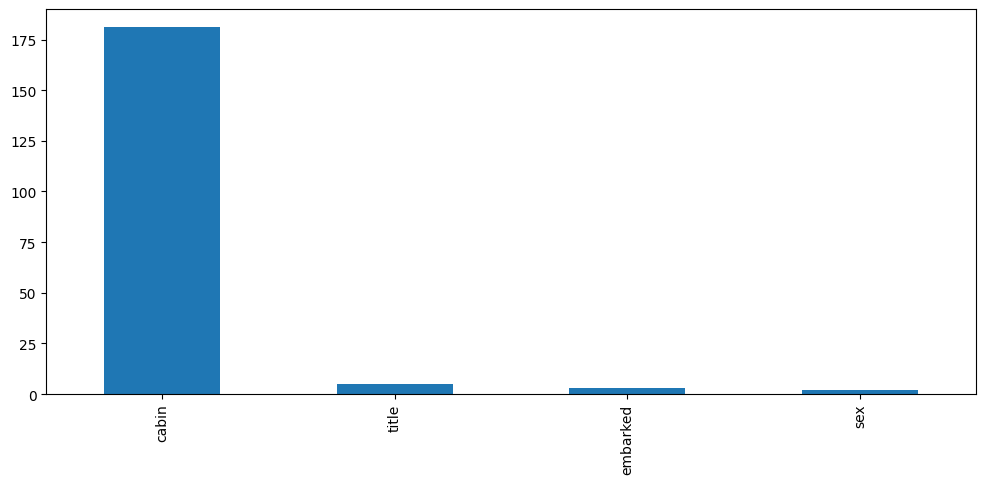

In [ ]:
# we count unique categories with pandas unique()
# and then plot them in descending order
data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

'cabin' categorical variables show high cardinality than the others. This means that 'cabin' variable have many different labels and the others have only few different labels.

*Conclusion: that isn't good because we will need to tackle cardinality during our feature engineering lecture.*

**Determine quality categorical variables**

There aren't a number of variables that refer to the quality of some aspect of the problem.

For example, about the probleme of house price prediction, for the garage or the fence or the kitchen we have the quality aspect describe like as following:
- Ex = Excellent
- Gd = Good
- TA = Average/Typical
- Fa =	Fair
- Po = Poor

When we have those variables, we need to replace these categories by numbers increasing with the quality of the place or room.


*Conclusion: But here, we don't have this categorical variable in our problem*



In [ ]:
# capture all quality variables
qual_vars_cat  = []

In [ ]:
# capture the remaining categorical variables
# (those that we did not re-map)
others_vars_cat = [var for var in vars_cat if var not in qual_vars_cat]
len(others_vars_cat)

4

**Rare labels:**

Let's go ahead and investigate now if there are labels that are present only in a small number of houses:

In [ ]:
def analyse_rare_labels(df, var, target, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)[target].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 5 % of the observations
RareLabels_vars_cat = []
for var in others_vars_cat:
    if not analyse_rare_labels(data, var, target, rare_perc=0.05).empty:
      print(analyse_rare_labels(data, var, target, rare_perc=0.05))
      RareLabels_vars_cat.append(var)
    print()
print(RareLabels_vars_cat)


cabin
A10    0.000764
A11    0.000764
A14    0.000764
A16    0.000764
A18    0.000764
         ...   
F33    0.003056
F38    0.000764
F4     0.003056
G6     0.003820
T      0.000764
Name: survived, Length: 181, dtype: float64


title
Master    0.046600
Other     0.023682
Name: survived, dtype: float64

['cabin', 'title']


'cabin' variable show multiple labels that are present in less than 1% of the houses.

Labels that are under-represented in the dataset tend to cause over-fitting of machine learning models.

*Conclusion: That is why we want to remove them.*

**Save the others categorical variable list**

In [ ]:
# Create a list
QUAL_CATEGORICAL_VARIABLES = qual_vars_cat
OTHERS_CATEGORICAL_VARIABLES = others_vars_cat
RARE_CATEGORICAL_VARIABLES = RareLabels_vars_cat

# Specify the file name to save the list to
QUAL_CATEGORICAL_VARIABLES_file_name = 'QUAL_CATEGORICAL_VARIABLES.pkl'
OTHERS_CATEGORICAL_VARIABLES_file_name = 'OTHERS_CATEGORICAL_VARIABLES.pkl'
RARE_CATEGORICAL_VARIABLES_file_name = 'RARE_CATEGORICAL_VARIABLES.pkl'

# Save the list to a file using pickle
with open(QUAL_CATEGORICAL_VARIABLES_file_name, 'wb') as file:
    pickle.dump(QUAL_CATEGORICAL_VARIABLES, file)

with open(OTHERS_CATEGORICAL_VARIABLES_file_name, 'wb') as file:
    pickle.dump(OTHERS_CATEGORICAL_VARIABLES, file)

with open(RARE_CATEGORICAL_VARIABLES_file_name, 'wb') as file:
    pickle.dump(RARE_CATEGORICAL_VARIABLES, file)


**Saving data after dataset Analysis and exploration**

In [ ]:
# save data for data analysis and exploration
data.to_csv('titanic_DataAnaEXp.csv', index=False)

# Conclusion

Now we finish Analysis and exploration of our data set.

The next steps are:

- Feature engeneering without pipeline method
- Feature engeneering with pipeline method
- Feature Selection
- Model Building

## **FEATURE ENGINEERING WITHOUT PIPELINE METHOD**

**Reproducibility: Setting the seed**


With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we set the seed.

In [ ]:
# fixing the seed
rng = 0

**Impute missing value in numerical variable**



*   for getting distribution of variables
*   for applying transformation whether is need



In [ ]:
# load dataset
data0 = pd.read_csv('/content/sample_data/titanic_DataAnaEXp.csv')

# rows and columns of the data
print(data0.shape)

# visualise the dataset
data0.head()

(1309, 10)


,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [ ]:
# copy the data set
data=data0.copy()

**The target**

Let's begin by exploring the target distribution.*texte en italique*

In [ ]:
# assign the target we want to predict
target = 'survived'
data_targ = data['survived']

In [ ]:
# check that that target columns is very well assign to data_target
data_targ.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

**No transformation applied**

Because it's classification problem, we don't need to apply transformation to target here

**Assignment Configuration for numerical variables**

In [ ]:
# list of variables to be used in the pipeline's transformers

## Numerical variables
# Specify the file name where list was saved
file_name = 'NUMERICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    NUMERICAL_VARIABLES = pickle.load(file)

## Numerical variables with NAN
# Specify the file name where list was saved
file_name = 'NUMERICAL_VARIABLES_WITH_NAN.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    NUMERICAL_VARIABLES_WITH_NAN = pickle.load(file)

## Numerical variables with NAN
# Specify the file name where list was saved
#file_name = 'NUMERICAL_VARIABLES_WITH_NAN_MISSING.pkl'
# Load the list from the file using pickle saved
#with open(file_name, 'rb') as file:
#    NUMERICAL_VARIABLES_WITH_NAN_MISSING = pickle.load(file)

## Numerical variables with NAN
# Specify the file name where list was saved
#file_name = 'NUMERICAL_VARIABLES_WITH_NAN_FREQUENT.pkl'
# Load the list from the file using pickle saved
#with open(file_name, 'rb') as file:
#    NUMERICAL_VARIABLES_WITH_NAN_FREQUENT = pickle.load(file)

## Temporal numerical variables
# Specify the file name where list was saved
file_name = 'TEMP_NUMERICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    TEMP_NUMERICAL_VARIABLES = pickle.load(file)

## Discrete numerical variables
# Specify the file name where list was saved
file_name = 'DISC_NUMERICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    DISC_NUMERICAL_VARIABLES = pickle.load(file)

## Continuous numerical variables
# Specify the file name where list was saved
file_name = 'CONT_NUMERICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    CONT_NUMERICAL_VARIABLES = pickle.load(file)

**Assignment Configuration for categorical variables**

In [ ]:
# list of variables to be used in the pipeline's transformers

## Load categorical variables
# Specify the file name where list was saved
file_name = 'CATEGORICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    CATEGORICAL_VARIABLES = pickle.load(file)

## Categorical variables with NAN
# Specify the file name where list was saved
file_name = 'CATEGORICAL_VARIABLES_WITH_NAN.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    CATEGORICAL_VARIABLES_WITH_NAN = pickle.load(file)

## Categorical variables with NAN witch will replaced by frequent value
# Specify the file name where list was saved
file_name = 'CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT = pickle.load(file)

## Categorical variables with NAN witch will replaced by 'Missing' labels
# Specify the file name where list was saved
file_name = 'CATEGORICAL_VARIABLES_WITH_NAN_MISSING.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    CATEGORICAL_VARIABLES_WITH_NAN_MISSING = pickle.load(file)

### variables to map
## Quality categorical variables
# Specify the file name where list was saved
file_name = 'QUAL_CATEGORICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    QUAL_CATEGORICAL_VARIABLES = pickle.load(file)

### Dictonnary for Mapping
QUAL_CATEGORICAL_VARIABLES_MAPPINGS = {}
#QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
#                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

## Others categorical variables or categorical variables to encode
# Specify the file name where list was saved
file_name = 'OTHERS_CATEGORICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    OTHERSCATEGORICAL_VARIABLES = pickle.load(file)

## Rare categorical variables
# Specify the file name where list was saved
file_name = 'RARE_CATEGORICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    RARE_CATEGORICAL_VARIABLES = pickle.load(file)

In [ ]:
# assign variable list loaded
vars_num = NUMERICAL_VARIABLES
vars_cat = CATEGORICAL_VARIABLES
vars_num_with_nan = NUMERICAL_VARIABLES_WITH_NAN
vars_cat_with_nan = CATEGORICAL_VARIABLES_WITH_NAN
vars_cat_nan_with_string_missing = CATEGORICAL_VARIABLES_WITH_NAN_MISSING
vars_cat_nan_with_frequent_category = CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT
temp_num_vars = TEMP_NUMERICAL_VARIABLES
discrete_vars_num = DISC_NUMERICAL_VARIABLES
cont_num_vars = CONT_NUMERICAL_VARIABLES
qual_vars_cat = QUAL_CATEGORICAL_VARIABLES
vars_cat_others = OTHERS_CATEGORICAL_VARIABLES
RareLabels_vars_cat = RARE_CATEGORICAL_VARIABLES

**Extract only the letter (and drop the number) from the variable Cabin**

In [ ]:
# remove all Numbers from Strings in the column 'cabin'
data['cabin'] = data['cabin'].str.replace('\d+', '', regex=True)
#data['cabin'] = data['cabin'].str[0] # captures the first letter

In [ ]:
# check that we capture the first letter of Strings in the column 'cabin'
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', nan, 'T', 'F', 'G'], dtype=object)

In [ ]:
# check that we capture the first letter of Strings in the column 'cabin'
data['cabin'].nunique()

8

**Treatment of missing value for numerical variable**

To engineer missing values in numerical variables, we will:

- add a binary missing indicator variable
- and then replace the missing values in the original variable with the mean (or mediane, ...)

In [ ]:
# replace missing values as we described above

for var in vars_num_with_nan:

    # calculate the mean using the train set
    mean_val = data[var].median() #mean()

    print(var, mean_val)

    # add binary missing indicator (in train and test)
    data[var + '_nan'] = np.where(data[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    data[var].fillna(mean_val, inplace=True)

age 28.0
fare 14.4542


In [ ]:
# check that we have no more missing values in the engineered variables
data[vars_num_with_nan].isnull().sum()

age     0
fare    0
dtype: int64

In [ ]:
# check that test set does not contain null values in the engineered variables
[var for var in vars_num_with_nan if data[var].isnull().sum() > 0]

[]

In [ ]:
# check the binary missing indicator variables
data[['age_nan', 'fare_nan']].head()

,age_nan,fare_nan
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [ ]:
# Get the column names with only positive values and convert it into list
# for np.log transformation
vars_num_log_tr = data[vars_num].columns[(data[vars_num] > 0).all()].tolist()

# Get the column names with only positive values and convert it into list
vars_num_pos = data[vars_num].columns[(data[vars_num] >= 0).all()].tolist()

# Get the column names with only positive values and convert it into list
vars_num_inv_tr = data[vars_num].columns[(data[vars_num] != 0).all()].tolist()

**Temporal variables**

There is no temporal variable here

**Treatment of missing value for categorical variable**

To engineer missing values in categorical variables, we will:

- We will replace missing values with the string "missing" in those variables with a lot of missing data
- Alternatively, we will replace missing data with the most frequent category in those variables that contain fewer observations without values

This is common practice.

In [ ]:
# variables to impute with the string missing
with_string_missing = [
    var for var in vars_cat_with_nan if data[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_frequent_category = [
    var for var in vars_cat_with_nan if data[var].isnull().mean() < 0.1]

In [ ]:
with_string_missing

['cabin']

In [ ]:
with_frequent_category

['embarked']

In [ ]:
# replace missing values (missing rate > 10%) with new label: "Missing"
data[with_string_missing] = data[with_string_missing].fillna('Missing')

In [ ]:
# replace missing values (missing rate < 10%) with frequent label: "Missing"
for var in with_frequent_category:

    # there can be more than 1 mode in a variable
    # we take the first one with [0]
    mode = data[var].mode()[0]

    print(var, mode)

    data[var].fillna(mode, inplace=True)

embarked S


In [ ]:
# Another way to proceede replacement of missing value
# replace all missing values with new label: "Missing"
#data[vars_cat] = data[vars_cat].fillna('Missing')

In [ ]:
# check that we have no missing information in the engineered variables
data[vars_cat_with_nan].isnull().sum()

cabin       0
embarked    0
dtype: int64

In [ ]:
# check that test set does not contain null values in the engineered variables
[var for var in vars_cat_with_nan if data[var].isnull().sum() > 0]

[]

**Outliers of numerical variables**

here are some common approaches to handling outliers:


*   **Data Transformation:**

Log Transformation: Apply a logarithmic transformation to the data, which can help reduce the impact of extreme values.


Box-Cox Transformation: Similar to log transformation but more flexible, as it can handle data that includes zero or negative values.
*   Trimming:

Simply remove outliers from your data set if they are rare and you believe that they are due to the errors or noise.

Remove a certain percentage of data points with the highest and lowest values.

This approach should be used cautiously, as it can result in a loss of information.

You can use this approach when you have a few outliers in your data set


*   Binning:

Create bins or categories for values, which can help reduce the impact of extreme values. This is common when dealing with continuous variables.

*   **Feature Engineering:**

Create new features that capture information about presence or abscence of Outliers in your data, such as binary flags indicating whether a data point is an outlier.

You can also create new features based on domain knowledge that are less susceptible to outliers. For example, instead of using raw values, you might use ratios or proportions.

*   **Robust Algorithms:**

Use machine learning algorithms that are less sensitive to outliers. For example, decision trees, random forests, Gradient boosting or Support vector machine can handle outliers to some extent.

*   **Anomaly Detection:**

Treat outliers as anomalies and build an anomaly detection model separately to identify and handle them.

*   **Outlier Detection Models:**

Train models to detect outliers and either remove them or assign them a different value.

*   **Leave Them As Is:**

In some cases, it might be best to leave outliers untouched, especially if they are not data errors but represent important information in your dataset.

In [ ]:
# make list of variables witch contains outliers data

# Define a function to detect outliers in a column
def detect_outliers_columns(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers

# Create an empty list to store columns with outliers
outliers_num_vars = []

# Loop through each column in the dataset
for column in vars_num:
    if data[column].dtype in ['int64', 'float64']:  # Check if the column contains numerical data
        outliers = detect_outliers_columns(data[column])
        if outliers.any():
            outliers_num_vars.append(column)

# Print the list of columns with outliers
print("Columns with Outliers:", outliers_num_vars)
# print the number of columns with outliers
print('Number of outliers columns: ', len(outliers_num_vars))

Columns with Outliers: ['age', 'sibsp', 'parch', 'fare']
Number of outliers columns:  4


In [ ]:
# Create new features that capture information about presence or abscence of Outliers in data set

for var in outliers_num_vars:
    # Identify outliers using IQR
    Q1 = np.percentile(data[var], 25)
    Q3 = np.percentile(data[var], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data[var] < lower_bound) | (data[var] > upper_bound)

    # add outliers indicator for each columns with outliers data
    data[var + '_outliers'] = np.where(outliers, 1, 0)

In [ ]:
# check if Outliers columns are created in data set
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title,age_nan,fare_nan,age_outliers,sibsp_outliers,parch_outliers,fare_outliers
0,1,1,female,29.0000,0,0,211.3375,B,S,Miss,0,0,0,0,0,1
1,1,1,male,0.9167,1,2,151.5500,C,S,Master,0,0,1,0,1,1
2,1,0,female,2.0000,1,2,151.5500,C,S,Miss,0,0,1,0,1,1
3,1,0,male,30.0000,1,2,151.5500,C,S,Mr,0,0,0,0,1,1
4,1,0,female,25.0000,1,2,151.5500,C,S,Mrs,0,0,0,0,1,1


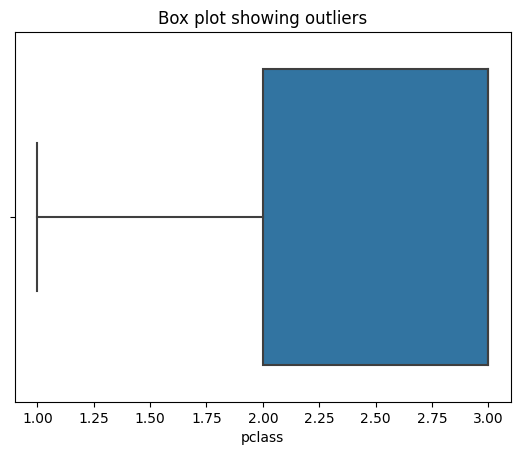

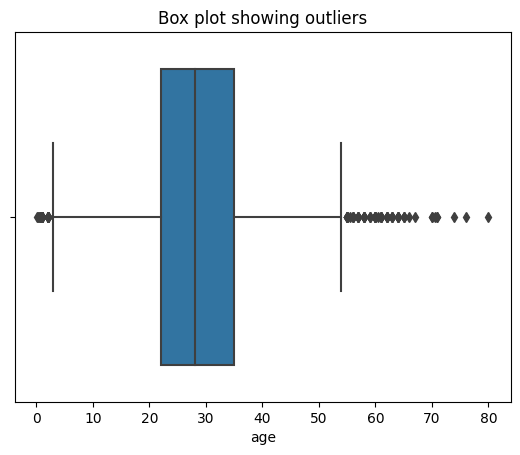

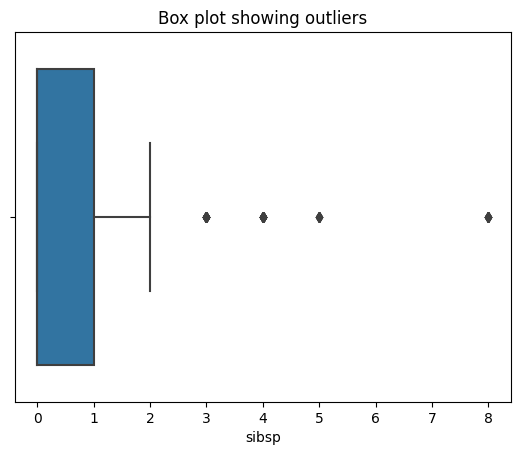

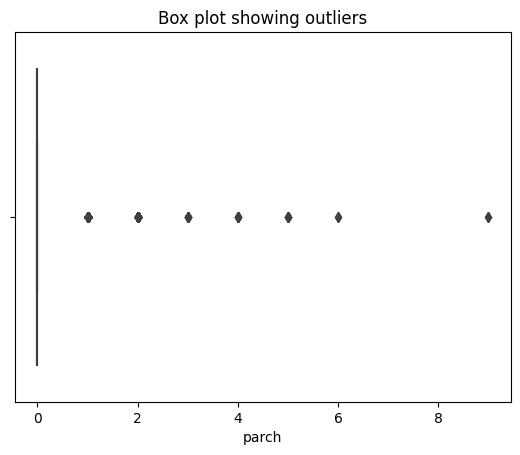

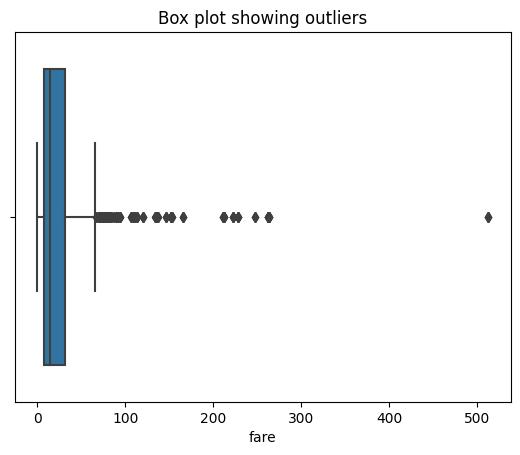

In [ ]:
# Code to see outliers in the variable
df = data
for var in vars_num:
  sns.boxplot(x = df[var])
  plt.title("Box plot showing outliers")
  plt.show()

*Conclusion: data set present 2 variables with outliers. So we will treate those variables in feature engeneering steps*

* Discrete variables
** with less or no outliers: 'sibsp' and 'parch' (7 and 8 clusters)
** with many outliers: no

* Continuous variables
** with less or no outliers: no
** with many outliers: no

**Save the outliers numerical variable list**

In [ ]:
# Create a list
OUTLIERS_NUMERICAL_VARIABLES = outliers_num_vars

# Specify the file name to save the list to
OUTLIERS_NUMERICAL_VARIABLES_file_name = 'OUTLIERS_NUMERICAL_VARIABLES.pkl'

# Save the list to a file using pickle
with open(OUTLIERS_NUMERICAL_VARIABLES_file_name, 'wb') as file:
    pickle.dump(OUTLIERS_NUMERICAL_VARIABLES, file)

**Determine the distribution of numerical variables**



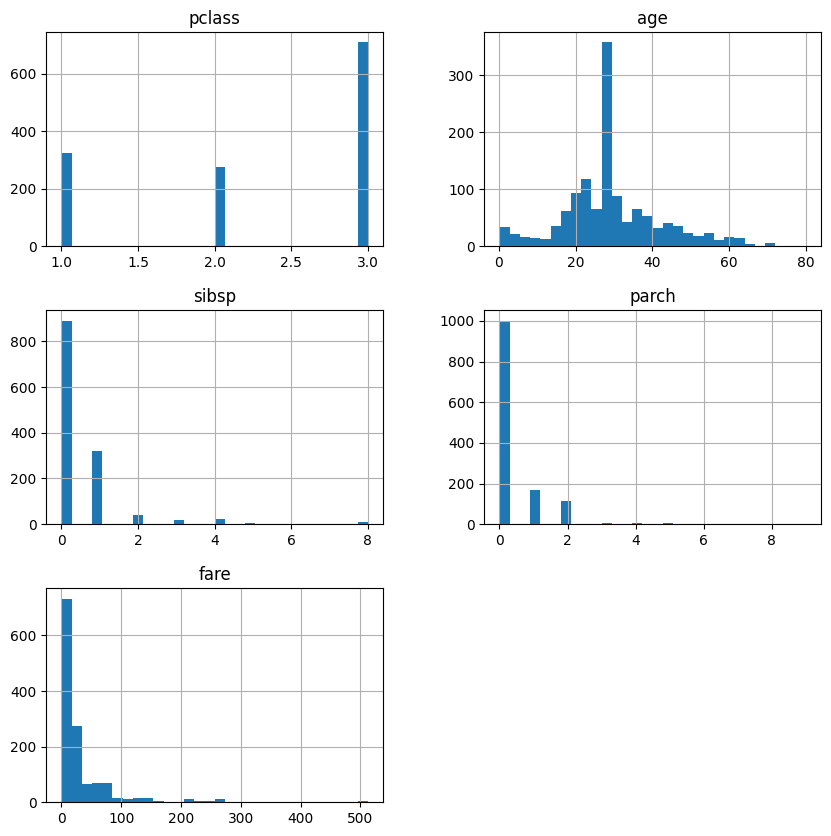

In [ ]:
# lets plot histograms for all continuous variables
data[vars_num].hist(bins=30, figsize=(10,10))
plt.show()

In [ ]:
# Define a function to detect skewed or unskewed variable
def detect_skeweness(num_var_list, dataframe):
    # to make a copy of dataset
    df = dataframe.copy()
    # Create an empty list to store columns with skewed
    skewed_num_vars = []
    skewness_value = []
    no_skewed_num_vars = []
    no_skewness_value = []

    for var in num_var_list:
      # Generate some example data (replace this with your dataset)
      data_set = df[var]

      # Calculate the skewness of the dataset
      skewness = skew(data_set)

      # Define a threshold for skewness (you can adjust this threshold as needed)
      threshold = 0.5  # You can set a different threshold based on your analysis

      # Check if the dataset is skewed or not
      if abs(skewness) > threshold:
          skewed_num_vars.append(var)
          skewness_value.append(skewness)
      else:
          no_skewed_num_vars.append(var)
          no_skewness_value.append(skewness)
    return skewed_num_vars, skewness_value, no_skewed_num_vars, no_skewness_value

In [ ]:
# Function to plot data transformed
def diagnostic_plots(df, variable):
    print("\n\n Feature name is : {}\n".format(variable))
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title("Histogram")
    df[variable].hist(bins='auto')
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()



 Feature name is : pclass



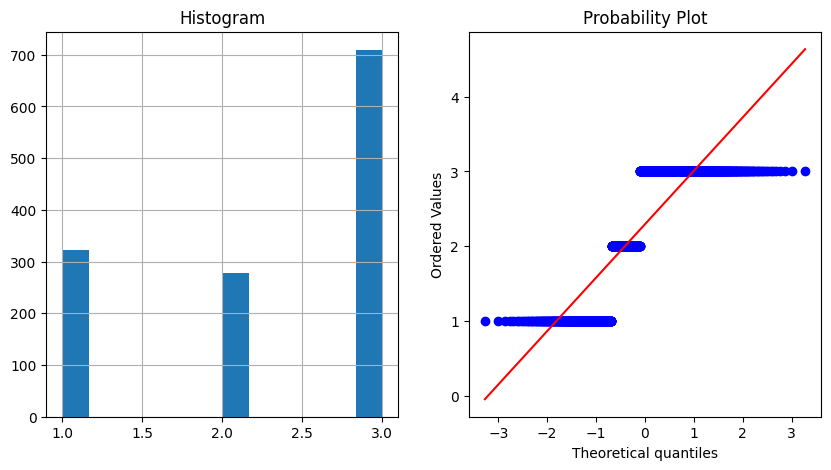



 Feature name is : age



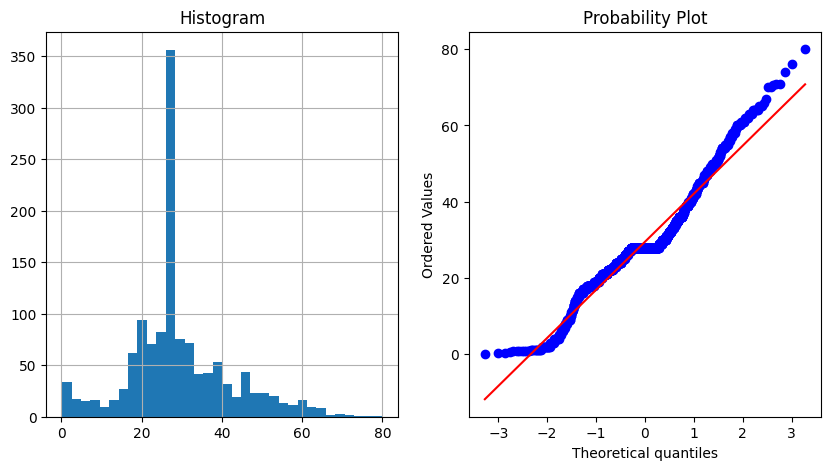



 Feature name is : sibsp



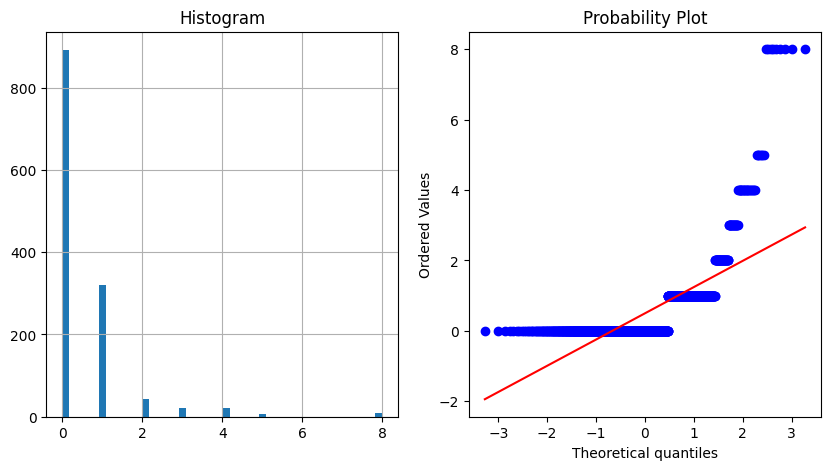



 Feature name is : parch



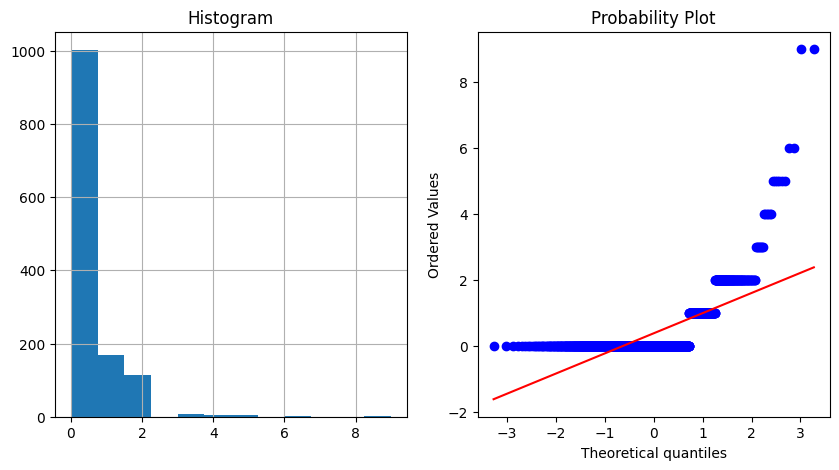



 Feature name is : fare



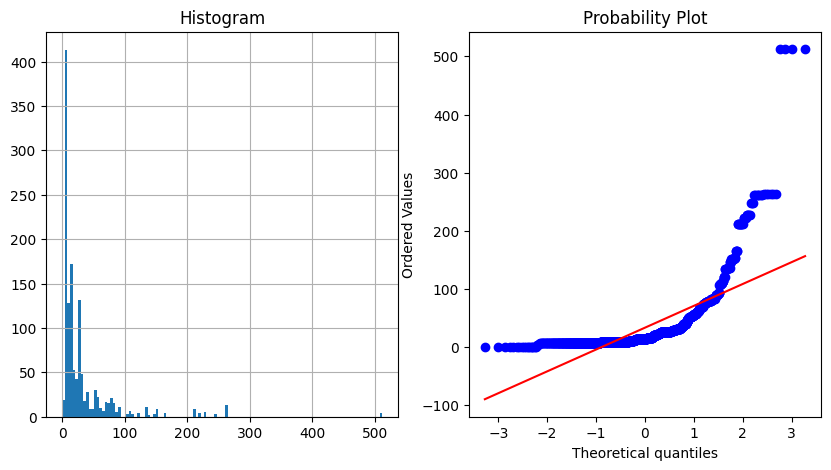

In [ ]:
# Plot the distribution of numerical variables

df = data # the dataframe you deal with
for col in vars_num: # df.columns
    diagnostic_plots(df, col)

In [ ]:
# get skweness of original variable
skweded = detect_skeweness(vars_num, data)

# check skewed variable
print("variable skewed, Skewness:", skweded[0], skweded[1])
print()
print("variable no skewed, Skewness:", skweded[2], skweded[3])

variable skewed, Skewness: ['pclass', 'age', 'sibsp', 'parch', 'fare'] [-0.5979608943517511, 0.5403638165934072, 3.8398137982535094, 3.6648724205383774, 4.3645008784110955]

variable no skewed, Skewness: [] []




 Feature name is : pclass



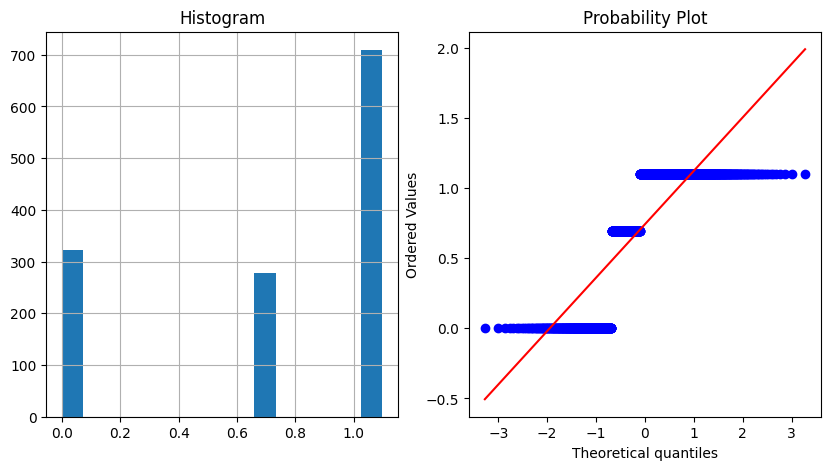



 Feature name is : age



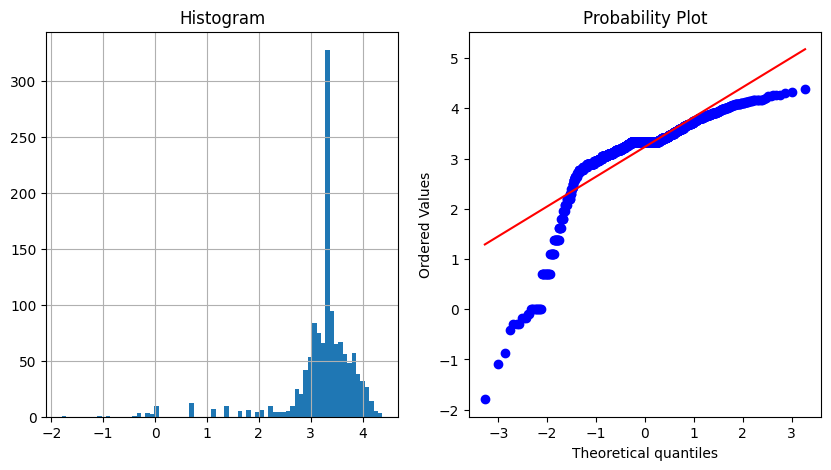

In [ ]:
## for logarithmic transformation
#create DataFrame
data_log_tr = pd.DataFrame(columns=vars_num_log_tr)

# transformers witch need only positive data
for var in vars_num_log_tr:
    data_log_tr[var] = np.log(data[var])

# plotting the variable
for col in vars_num_log_tr:
    diagnostic_plots(data_log_tr, col)

In [ ]:
# get skweness of transformed variable
skweded = detect_skeweness(vars_num_log_tr, data_log_tr)

# check skewed variable
print("variable skewed, Skewness:", skweded[0], skweded[1])
print()
print("variable no skewed, Skewness:", skweded[2], skweded[3])

variable skewed, Skewness: ['pclass', 'age'] [-0.8183963212344755, -2.907920127733517]

variable no skewed, Skewness: [] []




 Feature name is : pclass



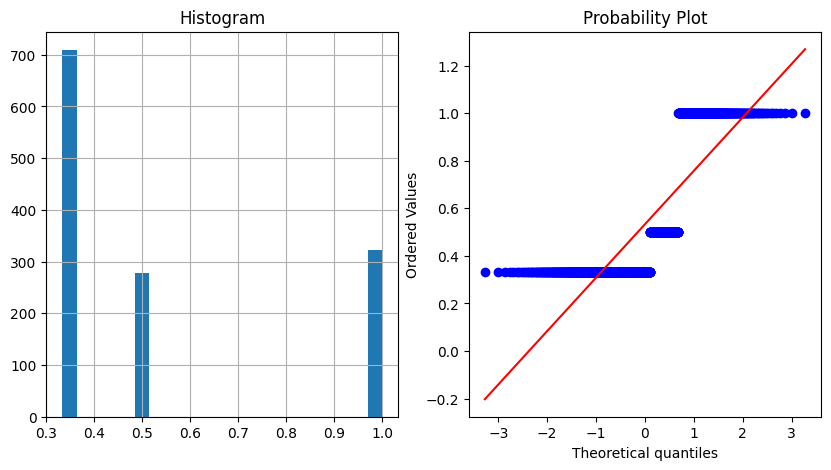



 Feature name is : age



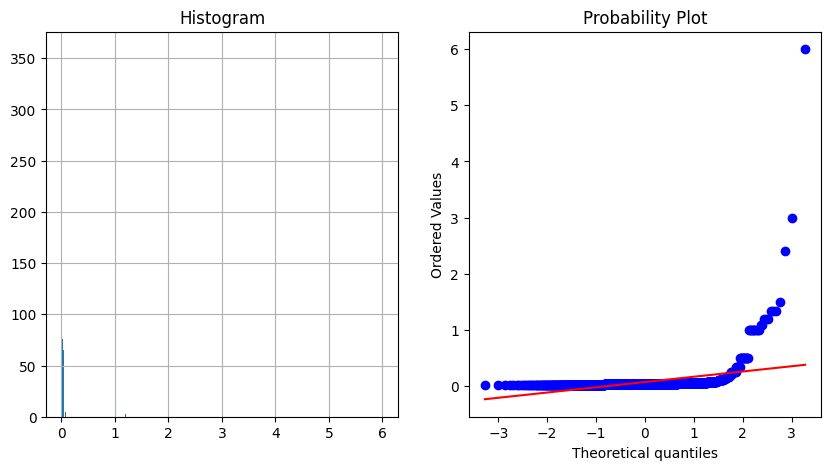

In [ ]:
## for inverse transformation
#create DataFrame
data_inv_tr = pd.DataFrame(columns=vars_num_inv_tr)

# transformers witch need data != 0
for var in vars_num_inv_tr:
    data_inv_tr[var] = 1/data[var]

# plotting the variable
for col in vars_num_inv_tr:
    diagnostic_plots(data_inv_tr, col)

In [ ]:
# get skweness of transformed variable
skweded = detect_skeweness(vars_num_inv_tr, data_inv_tr)

# check skewed variable
print("variable skewed, Skewness:", skweded[0], skweded[1])
print()
print("variable no skewed, Skewness:", skweded[2], skweded[3])

variable skewed, Skewness: ['pclass', 'age'] [0.9993442146265963, 14.958584950982296]

variable no skewed, Skewness: [] []




 Feature name is : pclass



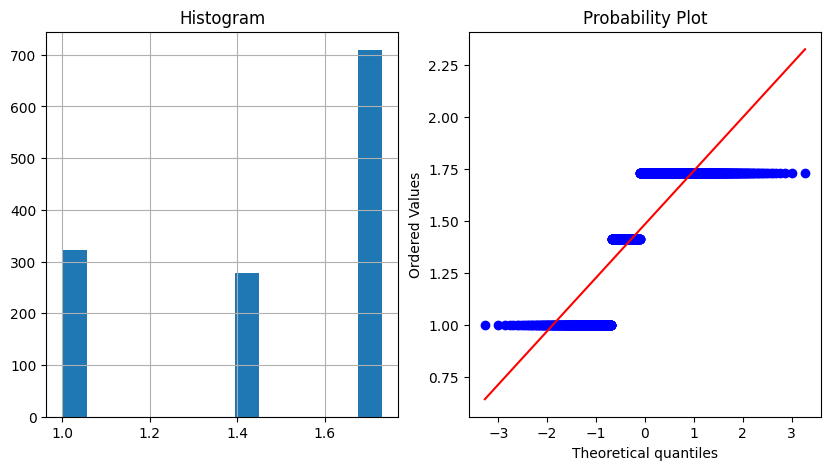



 Feature name is : age



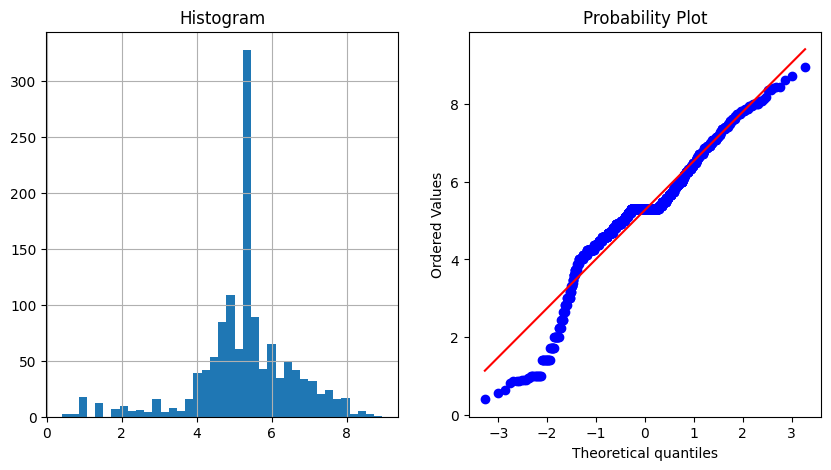



 Feature name is : sibsp



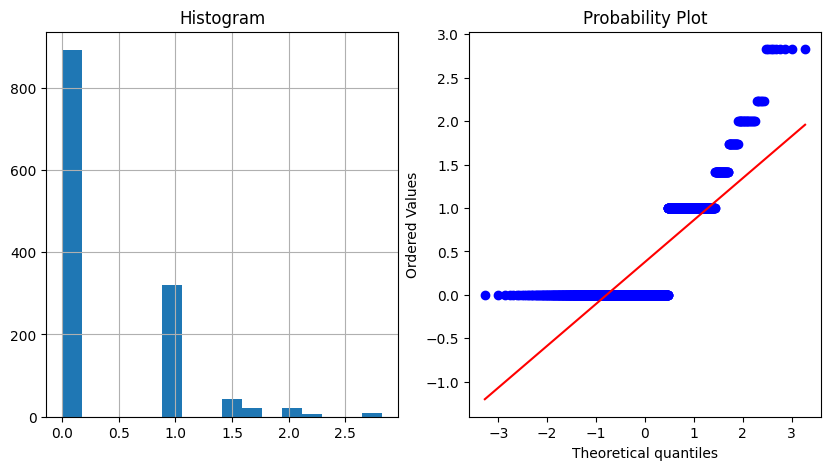



 Feature name is : parch



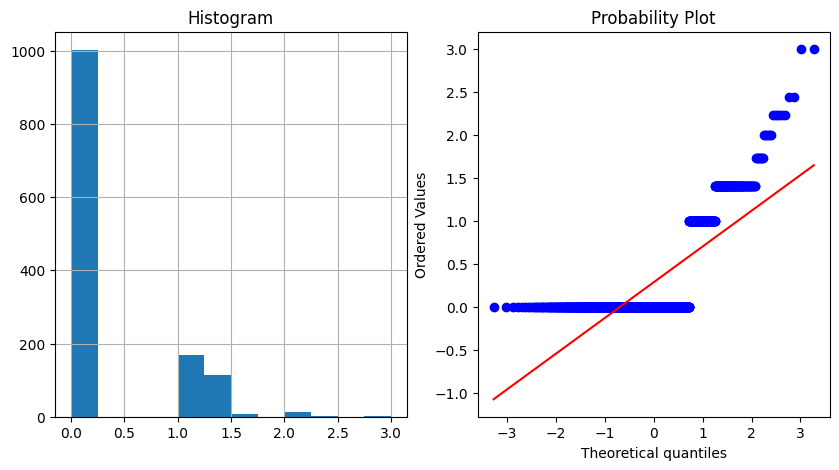



 Feature name is : fare



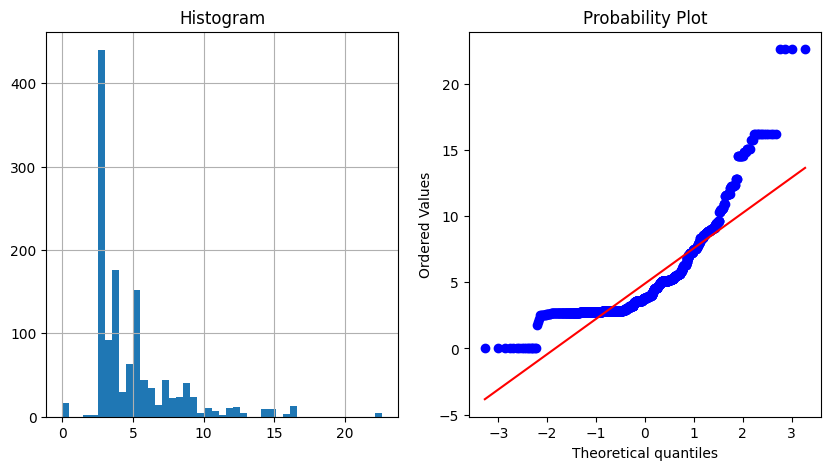

In [ ]:
## for square root transformation
#create DataFrame
data_sqrt_tr = pd.DataFrame(columns=vars_num_pos)

# transformers for positive data
for var in vars_num_pos:
    data_sqrt_tr[var] = np.sqrt(data[var])

# plotting the variable
for col in vars_num_pos:
    diagnostic_plots(data_sqrt_tr, col)

In [ ]:
# get skweness of transformed variable
skweded = detect_skeweness(vars_num_pos, data_sqrt_tr)

# check skewed variable
print("variable skewed, Skewness:", skweded[0], skweded[1])
print()
print("variable no skewed, Skewness:", skweded[2], skweded[3])

variable skewed, Skewness: ['pclass', 'age', 'sibsp', 'parch', 'fare'] [-0.7086107197217143, -0.749218774735562, 1.401705760837185, 1.64320628292042, 2.085895542715589]

variable no skewed, Skewness: [] []




 Feature name is : pclass



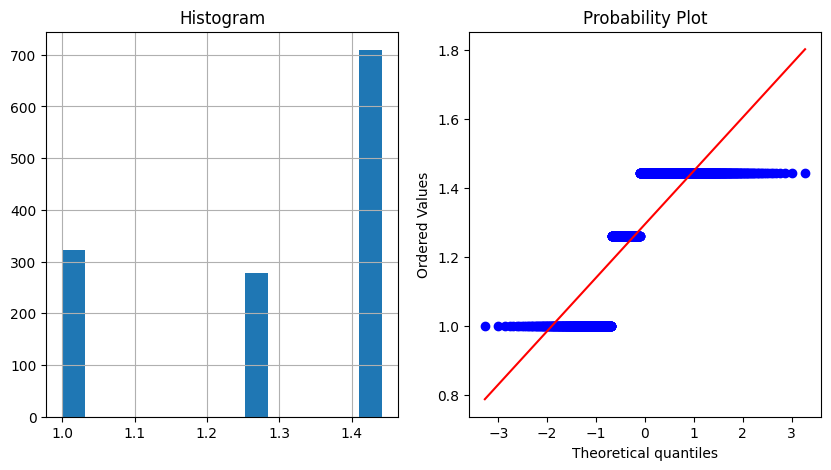



 Feature name is : age



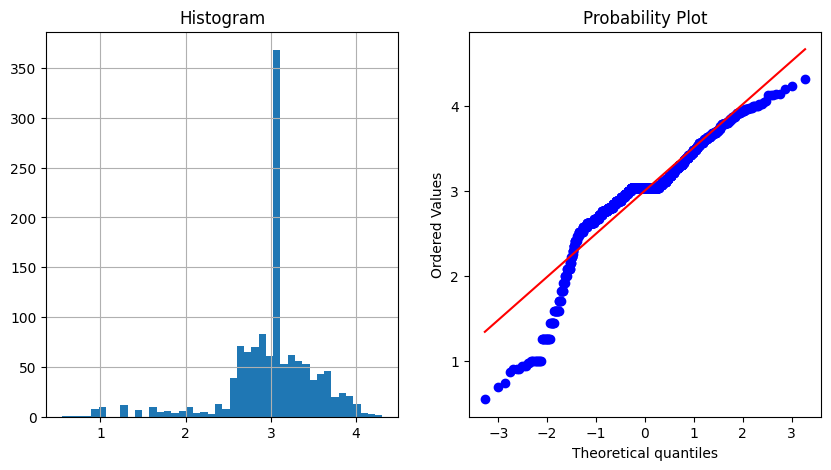



 Feature name is : sibsp



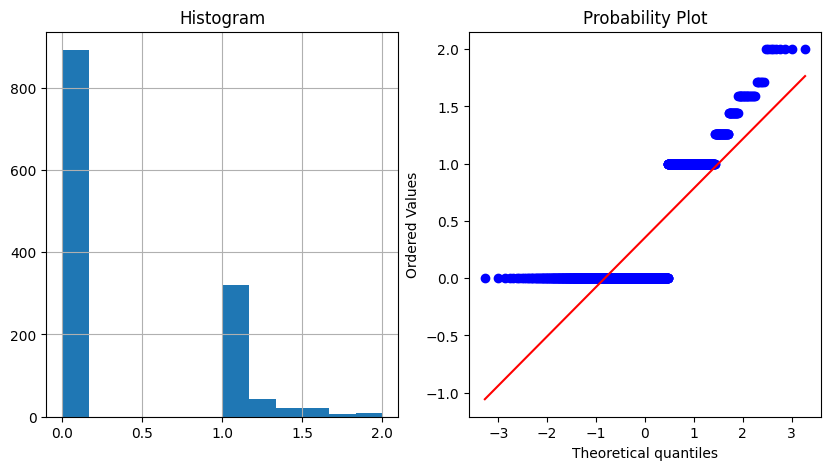



 Feature name is : parch



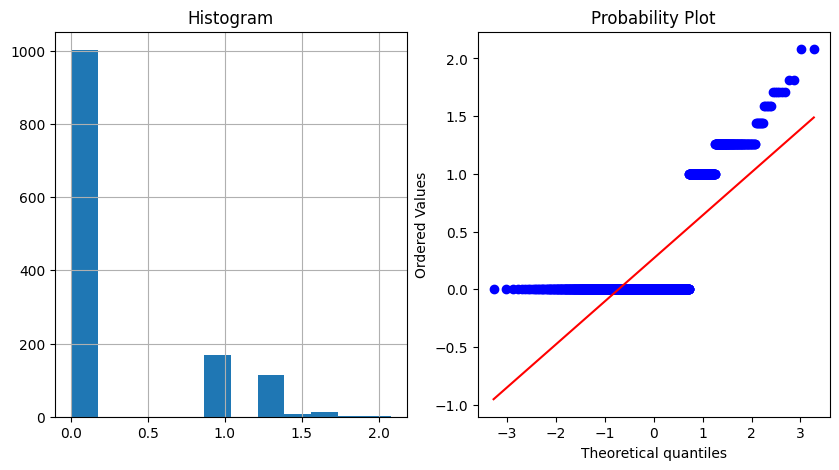



 Feature name is : fare



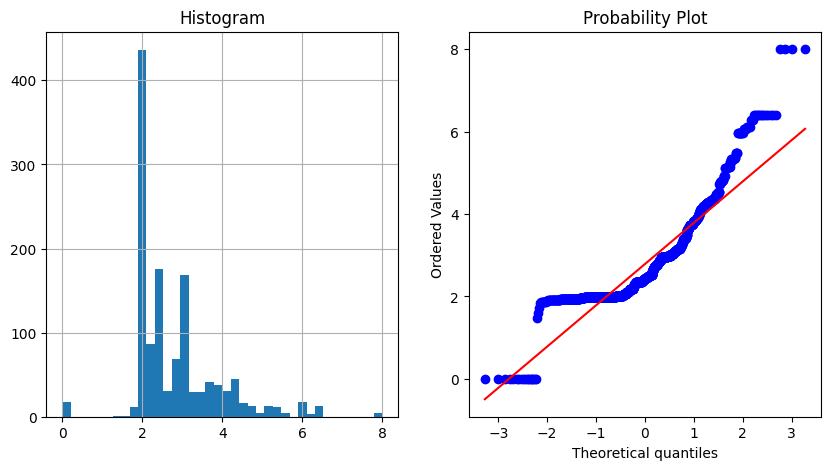

In [ ]:
## for cube root transformation
#create DataFrame
data_cbrt_tr = pd.DataFrame(columns=vars_num_pos)

# transformers for positive data
for var in vars_num_pos:
    data_cbrt_tr[var] = np.cbrt(data[var])

# plotting the variable
for col in vars_num_pos:
    diagnostic_plots(data_cbrt_tr, col)

In [ ]:
# get skweness of transformed variable
skweded = detect_skeweness(vars_num_pos, data_cbrt_tr)

# check skewed variable
print("variable skewed, Skewness:", skweded[0], skweded[1])
print()
print("variable no skewed, Skewness:", skweded[2], skweded[3])

variable skewed, Skewness: ['pclass', 'age', 'sibsp', 'parch', 'fare'] [-0.7458093343546488, -1.3563668934223942, 1.0060928410705716, 1.4012226377169916, 1.34583245187683]

variable no skewed, Skewness: [] []




 Feature name is : pclass



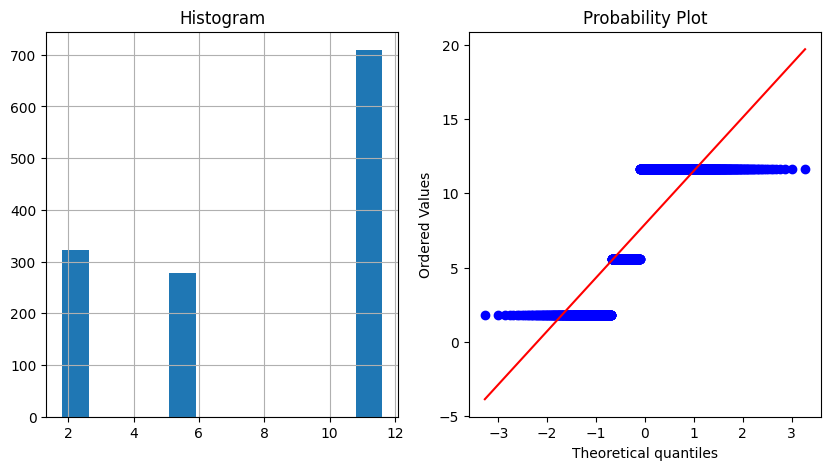



 Feature name is : age



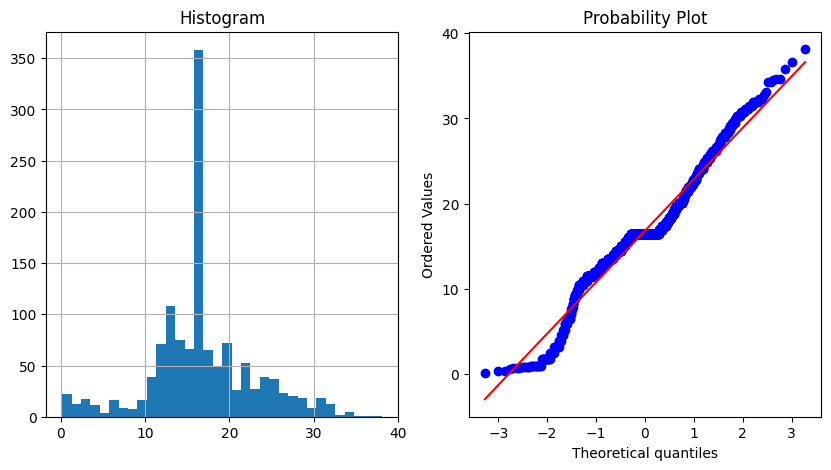



 Feature name is : sibsp



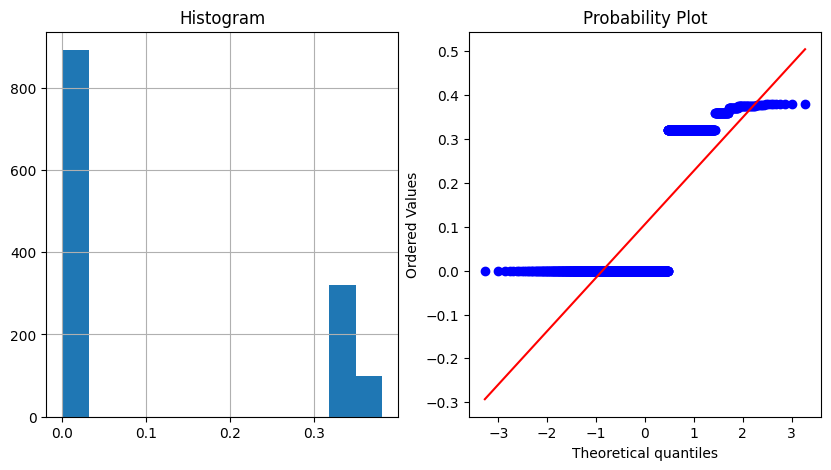



 Feature name is : parch



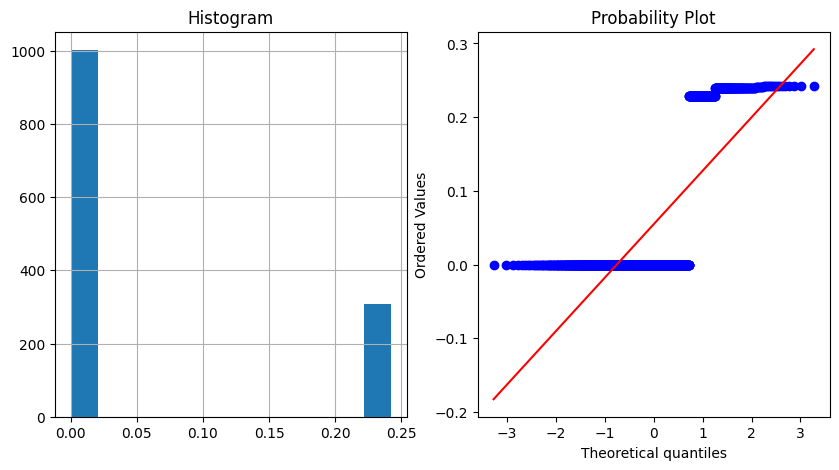



 Feature name is : fare



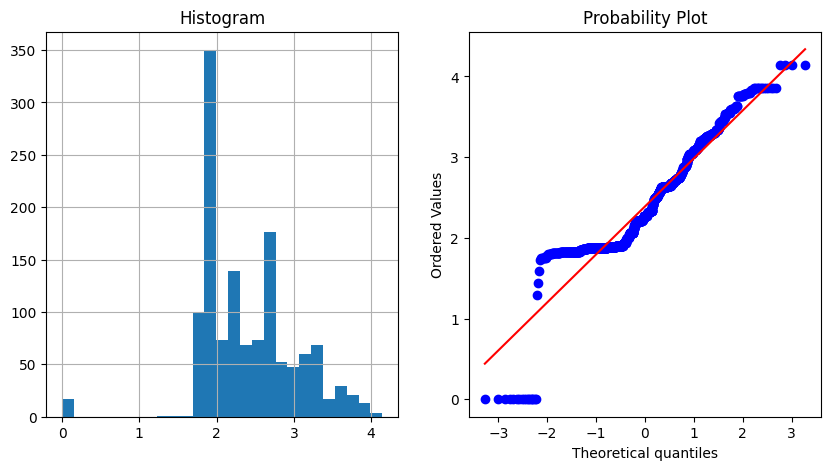

In [ ]:
## for yeo-johnson transformation
#create DataFrame
data_yeojohn_tr = pd.DataFrame(columns=vars_num)

# transformers for negative and positive data
for var in vars_num:
    data_yeojohn_tr[var], param = stats.yeojohnson(data[var])

# plotting the variable
for col in vars_num:
    diagnostic_plots(data_yeojohn_tr, col)

In [ ]:
# get skweness of transformed variable
skweded = detect_skeweness(vars_num, data_yeojohn_tr)

# check skewed variable
print("variable skewed, Skewness:", skweded[0], skweded[1])
print()
print("variable no skewed, Skewness:", skweded[2], skweded[3])

variable skewed, Skewness: ['sibsp', 'parch'] [0.7956556002315318, 1.2559732174257006]

variable no skewed, Skewness: ['pclass', 'age', 'fare'] [-0.41841547951833097, 0.0877835144536861, -0.05688235278283054]




 Feature name is : pclass



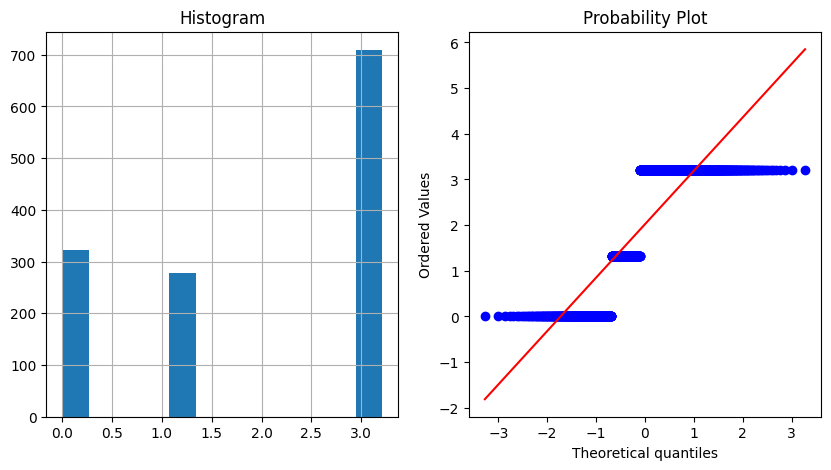



 Feature name is : age



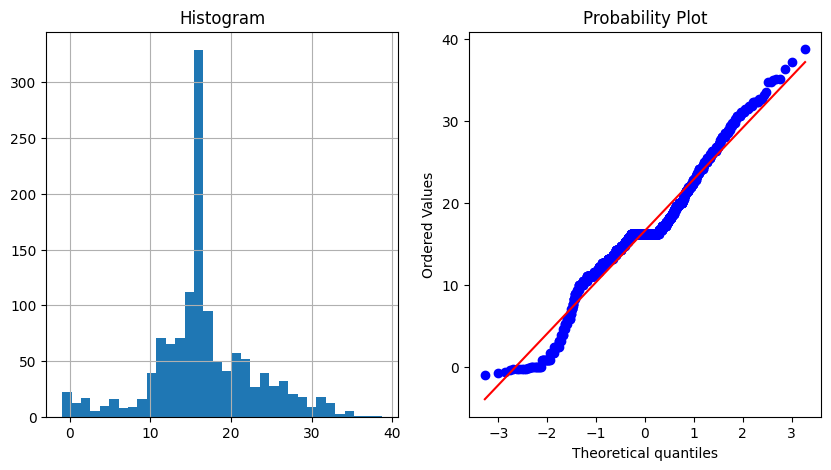

In [ ]:
## for boxcox transformation
#create DataFrame
data_boxcox_tr = pd.DataFrame(columns=vars_num_log_tr)

# transformers for strictly positive data
for var in vars_num_log_tr:
    data_boxcox_tr[var], param = stats.boxcox(data[var])

# plotting the variable
for col in vars_num_log_tr:
    diagnostic_plots(data_boxcox_tr, col)

In [ ]:
# get skweness of transformed variable
skweded = detect_skeweness(vars_num_log_tr, data_boxcox_tr)

# check skewed variable
print("variable skewed, Skewness:", skweded[0], skweded[1])
print()
print("variable no skewed, Skewness:", skweded[2], skweded[3])

# save unskewed variable after apply transformation
no_skewed_num_vars_boxcox = skweded[2]

variable skewed, Skewness: [] []

variable no skewed, Skewness: ['pclass', 'age'] [-0.45977570751719593, 0.07407419339253518]




 Feature name is : pclass



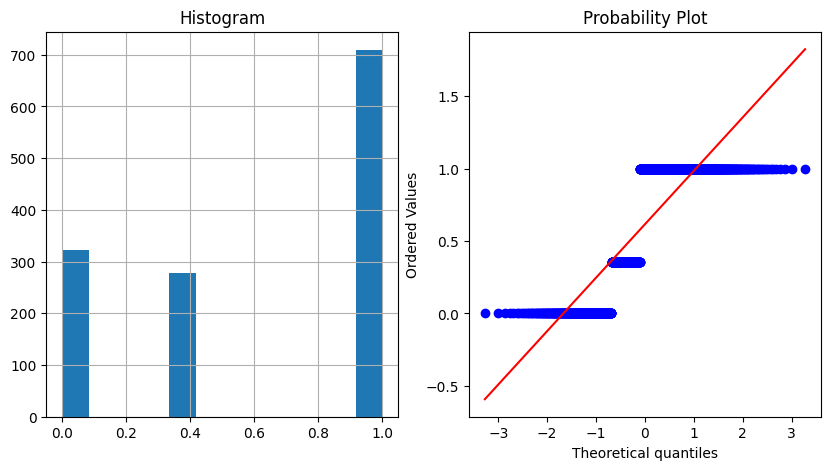



 Feature name is : age



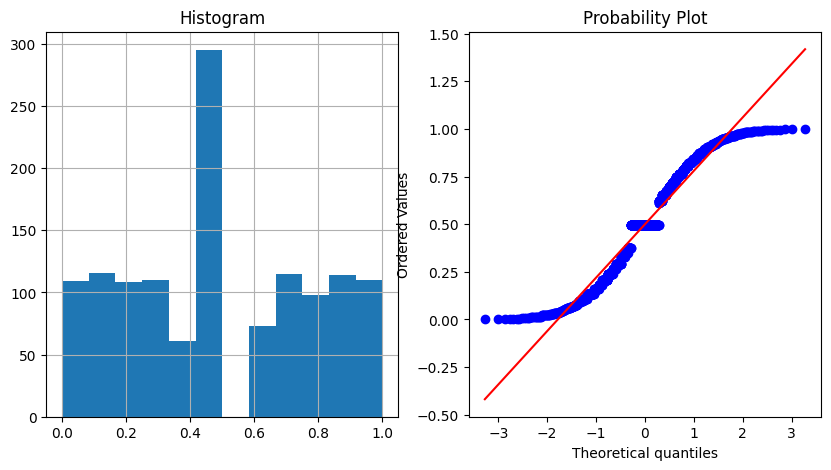



 Feature name is : sibsp



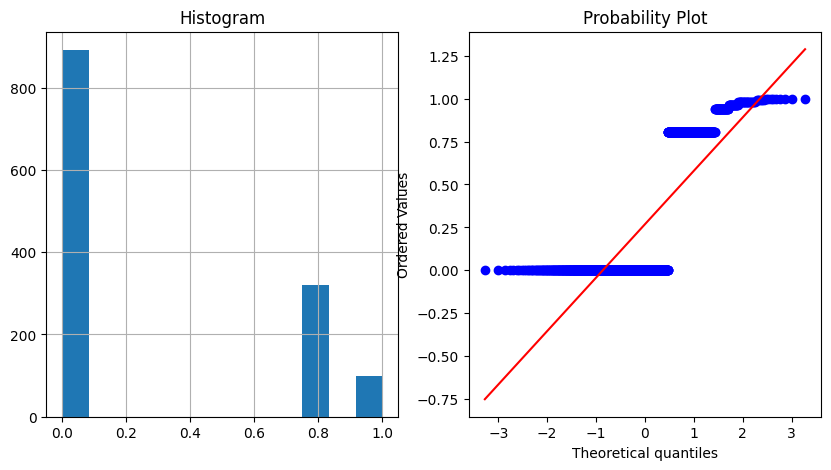



 Feature name is : parch



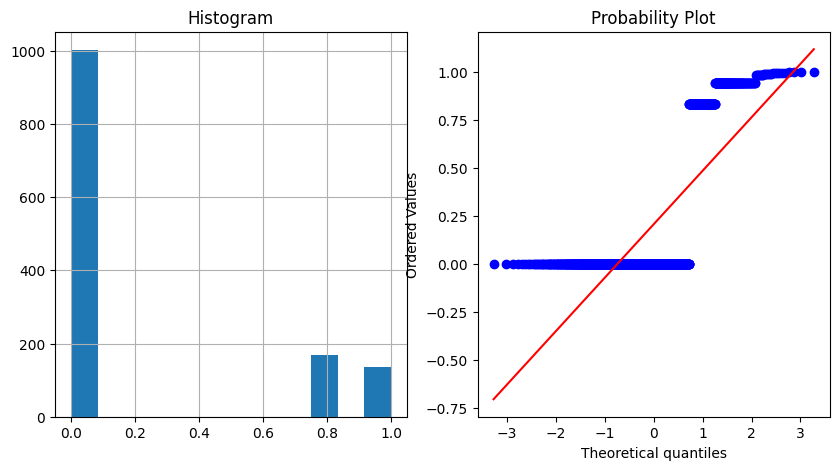



 Feature name is : fare



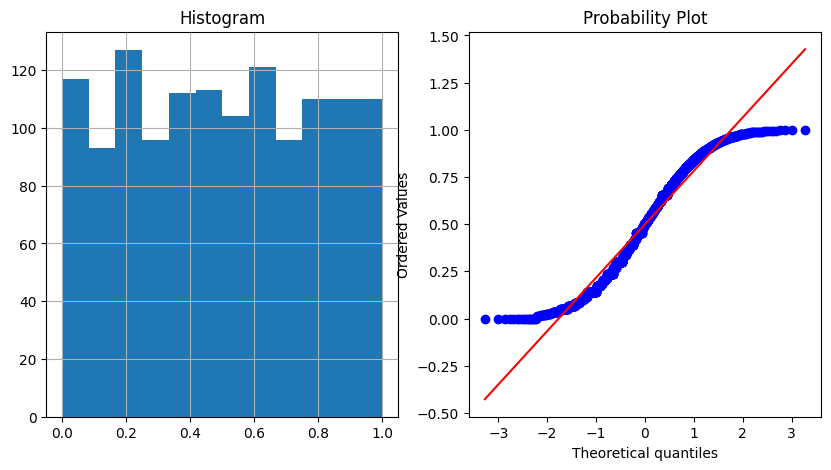

In [ ]:
## for Quantile transformation
#create DataFrame
data_quant_tr = pd.DataFrame(columns=vars_num)
for var in vars_num:
    data_quant_tr[var] = data[var]

# transformers for negative and positive data
quanTr = QuantileTransformer(random_state=rng)
data_quant_tr = pd.DataFrame(quanTr.fit_transform(data_quant_tr), columns=vars_num)

# plotting the variable
for col in vars_num:
    diagnostic_plots(data_quant_tr, col)

In [ ]:
# get skweness of transformed variable
skweded = detect_skeweness(vars_num, data_quant_tr)

# check skewed variable
print("variable skewed, Skewness:", skweded[0], skweded[1])
print()
print("variable no skewed, Skewness:", skweded[2], skweded[3])

# save unskewed variable after apply transformation
no_skewed_num_vars_quantile = skweded[2]

variable skewed, Skewness: ['sibsp', 'parch'] [0.8085110241421026, 1.2744594504644808]

variable no skewed, Skewness: ['pclass', 'age', 'fare'] [-0.3796355652437975, 0.0009425220332997809, -0.0008640752355832153]




 Feature name is : pclass



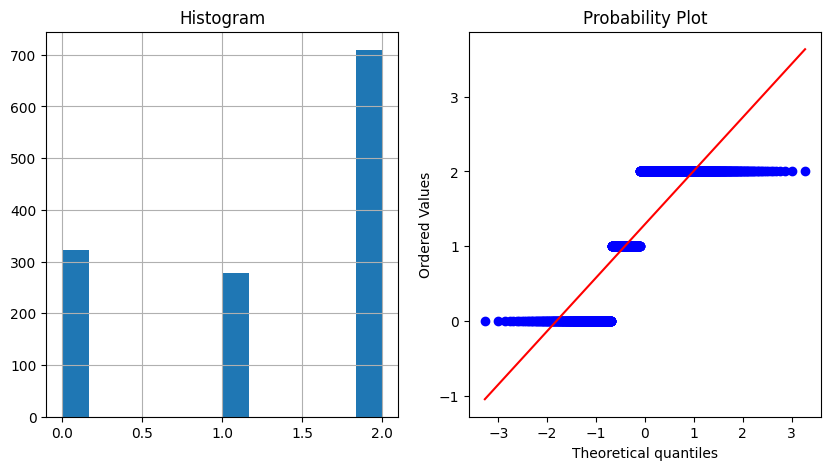



 Feature name is : sibsp



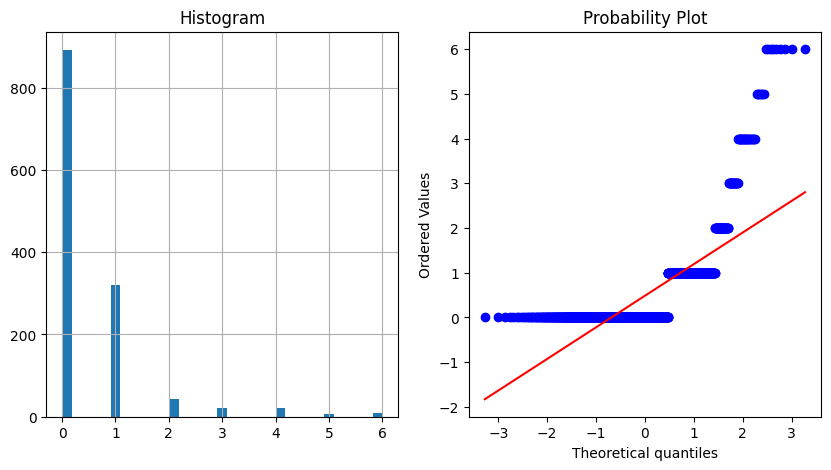



 Feature name is : parch



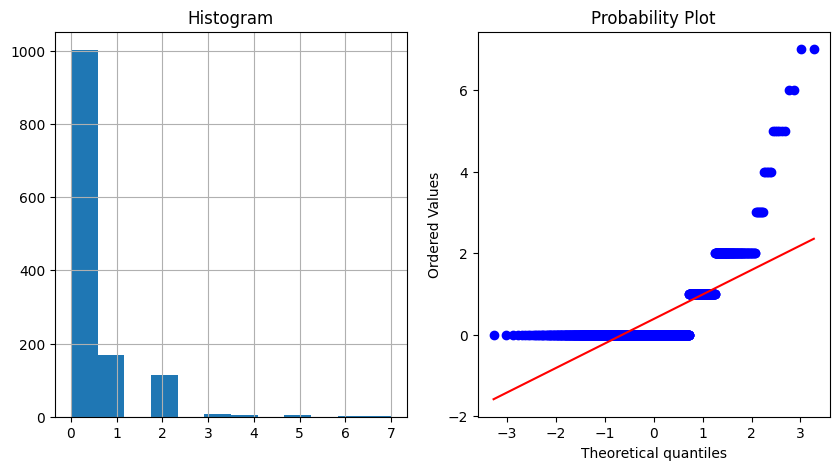

In [ ]:
## for KBinsDiscretizer transformation
# define KBinsDiscretizer transformer
feature_transformer = ColumnTransformer(
    transformers=[
        ('pclass', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans'), [0]),
        ('sibsp', KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='kmeans'), [1]),
        ('parch', KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='kmeans'), [2])
    ],
    remainder='passthrough'
)

#create DataFrame
data_kbin_tr = pd.DataFrame(columns=discrete_vars_num)
for var in discrete_vars_num:
    data_kbin_tr[var] = data[var]

# transformers for negative and positive data
data_kbin_tr = pd.DataFrame(feature_transformer.fit_transform(data_kbin_tr), columns=discrete_vars_num)

# plotting the variable
for col in discrete_vars_num:
    diagnostic_plots(data_kbin_tr, col)

In [ ]:
# get skweness of transformed variable
skweded = detect_skeweness(discrete_vars_num, data_kbin_tr)

# check skewed variable
print("variable skewed, Skewness:", skweded[0], skweded[1])
print()
print("variable no skewed, Skewness:", skweded[2], skweded[3])

variable skewed, Skewness: ['pclass', 'sibsp', 'parch'] [-0.5979608943517506, 3.0362138146662874, 3.1374162412738937]

variable no skewed, Skewness: [] []


In [ ]:
# save skewed and unskewed variable
no_skewed_num_vars = ['pclass', 'age', 'fare'] # with QuantileTransformer(random_state=rng)
# no_skewed_num_vars = ['pclass', 'age'] # with boxcox
# no_skewed_num_vars = ['pclass', 'age', 'fare'] # with yeo-johnson

skewed_num_vars = [var for var in vars_num if var not in no_skewed_num_vars]


# check skewed and unskewed variable
print("variable skewed:", skewed_num_vars)
print()
print("variable unskewed:", no_skewed_num_vars)

variable skewed: ['sibsp', 'parch']

variable unskewed: ['pclass', 'age', 'fare']


**Save the skewed and no skewed numerical variable list**

In [ ]:
# general skewed and unskewed variable
# Create a list
#SKEWED_NUMERICAL_VARIABLES = skewed_num_vars
#NO_SKEWED_NUMERICAL_VARIABLES = no_skewed_num_vars

# Specify the file name to save the list to
#SKEWED_NUMERICAL_VARIABLES_file_name = 'SKEWED_NUMERICAL_VARIABLES.pkl'
#NO_SKEWED_NUMERICAL_VARIABLES_file_name = 'NO_SKEWED_NUMERICAL_VARIABLES.pkl'

# Save the list to a file using pickle
#with open(SKEWED_NUMERICAL_VARIABLES_file_name, 'wb') as file:
#    pickle.dump(SKEWED_NUMERICAL_VARIABLES, file)

# Save the list to a file using pickle
#with open(NO_SKEWED_NUMERICAL_VARIABLES_file_name, 'wb') as file:
#    pickle.dump(NO_SKEWED_NUMERICAL_VARIABLES, file)

**Save no skewed numerical variable list of transformation chosen and the skewed variable**

In [ ]:
# list of variable witch becomes unskewed after apply transformation
# Create a list
QUANTILE_NO_SKEWED_NUMERICAL_VARIABLES = no_skewed_num_vars_quantile
SKEWED_NUMERICAL_VARIABLES = [var for var in vars_num if var not in no_skewed_num_vars_quantile]

# Specify the file name to save the list to
QUANTILE_NO_SKEWED_NUMERICAL_VARIABLES_file_name = 'QUANTILE_NO_SKEWED_NUMERICAL_VARIABLES.pkl'
SKEWED_NUMERICAL_VARIABLES_file_name = 'SKEWED_NUMERICAL_VARIABLES.pkl'

# Save the list to a file using pickle
# Save the list to a file using pickle
with open(QUANTILE_NO_SKEWED_NUMERICAL_VARIABLES_file_name, 'wb') as file:
    pickle.dump(QUANTILE_NO_SKEWED_NUMERICAL_VARIABLES, file)

with open(SKEWED_NUMERICAL_VARIABLES_file_name, 'wb') as file:
    pickle.dump(SKEWED_NUMERICAL_VARIABLES, file)

*Conclusion: all numerical variable in data set are skewed*



*   less skewed : ['pclass', 'age'] and skeweness are [-0.5979608943517511, 0.5403638165934072]
*   extremely skewed : ['sibsp', 'parch', 'fare'] and skeweness are [3.8398137982535094, 3.6648724205383774, 4.3645008784110955]

So we will binarize the skewed variable and apply transformation to no skewed variable in order to obtain more normal distribution

**Binarize skewed variables**

We don't have here a variable very skewed, so we would not transform those into binary variables.

In [ ]:
# Binarize skewed variables
for var in SKEWED_NUMERICAL_VARIABLES:
    # map the variable values into 0 and 1
    data[var] = np.where(data[var]==0, 0, 1)

**Removing Rare Labels**

For the remaining categorical variables, we will group those categories that are present in less than 5% of the observations. That is, all values of categorical variables that are shared by less than 5% of total values of variables, well be replaced by the string "Rare".

To learn more about how to handle categorical variables visit our course [Feature Engineering for Machine Learning](https://www.trainindata.com/p/feature-engineering-for-machine-learning).

In [ ]:
# capture all quality variables
#vars_cat_qual  = []

# capture the remaining categorical variables
# (those that we did not re-map)
#vars_cat_others = [var for var in vars_cat if var not in vars_cat_qual]

# print number of others categorical variables
len(vars_cat_others)

4

In [ ]:
def find_frequent_labels(df, var, rare_perc):

    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset
    df = df.copy()
    tmp = df.groupby(var)[var].count() / len(df)
    return tmp[tmp > rare_perc].index


for var in vars_cat_others:

    # find the frequent categories
    frequent_ls = find_frequent_labels(data, var, rare_perc=0.05)

    print(var, frequent_ls)
    print()

    # replace rare categories by the string "Rare"
    data[var] = np.where(data[var].isin(frequent_ls), data[var], 'Rare')

sex Index(['female', 'male'], dtype='object', name='sex')

cabin Index(['C', 'Missing'], dtype='object', name='cabin')

embarked Index(['C', 'Q', 'S'], dtype='object', name='embarked')

title Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='title')



In [ ]:
# check that we have 'Rare' labels in the column
data[vars_cat].nunique()

sex         2
cabin       3
embarked    3
title       4
dtype: int64

In [ ]:
# check that we have 'Rare' labels in the column
for var in vars_cat:
  print(var, data[var].unique())

sex ['female' 'male']
cabin ['Rare' 'C' 'Missing']
embarked ['S' 'C' 'Q']
title ['Miss' 'Rare' 'Mr' 'Mrs']


**Perform one hot encoding of categorical variables into k-1 binary variables**

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [ ]:
for var in vars_cat_others:
    # to create the binary variables, we use get_dummies from pandas
    data = pd.concat([data, pd.get_dummies(data[var], prefix=var, drop_first=True)], axis=1)

# Drop or remove the variable encoded
data.drop(labels=vars_cat_others, axis=1, inplace=True)

# visualise the dataset
data.head()

# One-Hot Encoding of Categorical Column Using Pandas library
#ohe_data = pd.get_dummies(data, columns = ['sex', 'cabin', 'embarked', 'title'])

#ohe_data.head()

,pclass,survived,age,sibsp,parch,fare,age_nan,fare_nan,age_outliers,sibsp_outliers,parch_outliers,fare_outliers,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare
0,1,1,29.0000,0,0,211.3375,0,0,0,0,0,1,0,0,1,0,1,0,0,0
1,1,1,0.9167,1,1,151.5500,0,0,1,0,1,1,1,0,0,0,1,0,0,1
2,1,0,2.0000,1,1,151.5500,0,0,1,0,1,1,0,0,0,0,1,0,0,0
3,1,0,30.0000,1,1,151.5500,0,0,0,0,1,1,1,0,0,0,1,1,0,0
4,1,0,25.0000,1,1,151.5500,0,0,0,0,1,1,0,0,0,0,1,0,1,0



**Saving data**

In [ ]:
# save the data set after perform feature engeneering
data.to_csv('titanic_DataFE.csv', index=False)

# get a list of all variable after performing feature engeneering
ALL_FEATURES_AFTER_FEATURE_ENGENEERING = (data.drop('survived', axis=1).columns).tolist()

# Specify the file name to save the list to
ALL_FEATURES_AFTER_FEATURE_ENGENEERING_file_name = 'ALL_FEATURES_AFTER_FEATURE_ENGENEERING.pkl'

# Save the list to a file using pickle
# Save the list to a file using pickle
with open(ALL_FEATURES_AFTER_FEATURE_ENGENEERING_file_name, 'wb') as file:
    pickle.dump(ALL_FEATURES_AFTER_FEATURE_ENGENEERING, file)

# Conclusion

Now we finish feature engeneering without pipeline method of our data set.

The next steps are:

- Feature engeneering with pipeline method
- Feature Selection
- Model Building

## **FEATURE ENGINEERING WITH PIPELINE METHOD**

**Data Load**

**Reproducibility: Setting the seed**


With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we set the seed.

In [ ]:
# fixing the seed
rng = 0

In [ ]:
# load dataset
data0 = pd.read_csv('/content/sample_data/titanic_DataAnaEXp.csv')

# rows and columns of the data
print(data0.shape)

# visualise the dataset
data0.head()

(1309, 10)


,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [ ]:
# copy the data set
data=data0.copy()

**The target**

Let's begin by exploring the target distribution.*texte en italique*

In [ ]:
# assign the target we want to predict
target = 'survived'
data_targ = data['survived']

In [ ]:
# check that that target columns is very well assign to data_target
data_targ.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

**No transformation applied**

Because it's classification problem, we don't need to apply transformation to target here

**Assignment Configuration for numerical variables**

In [ ]:
# list of variables to be used in the pipeline's transformers

## Numerical variables
# Specify the file name where list was saved
file_name = 'NUMERICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    NUMERICAL_VARIABLES = pickle.load(file)

## Numerical variables with NAN
# Specify the file name where list was saved
file_name = 'NUMERICAL_VARIABLES_WITH_NAN.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    NUMERICAL_VARIABLES_WITH_NAN = pickle.load(file)

## Numerical variables with NAN
# Specify the file name where list was saved
#file_name = 'NUMERICAL_VARIABLES_WITH_NAN_MISSING.pkl'
# Load the list from the file using pickle saved
#with open(file_name, 'rb') as file:
#    NUMERICAL_VARIABLES_WITH_NAN_MISSING = pickle.load(file)

## Numerical variables with NAN
# Specify the file name where list was saved
#file_name = 'NUMERICAL_VARIABLES_WITH_NAN_FREQUENT.pkl'
# Load the list from the file using pickle saved
#with open(file_name, 'rb') as file:
#    NUMERICAL_VARIABLES_WITH_NAN_FREQUENT = pickle.load(file)

## Temporal numerical variables
# Specify the file name where list was saved
file_name = 'TEMP_NUMERICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    TEMP_NUMERICAL_VARIABLES = pickle.load(file)

## Discrete numerical variables
# Specify the file name where list was saved
file_name = 'DISC_NUMERICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    DISC_NUMERICAL_VARIABLES = pickle.load(file)

## Continuous numerical variables
# Specify the file name where list was saved
file_name = 'CONT_NUMERICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    CONT_NUMERICAL_VARIABLES = pickle.load(file)

# Numerical variables for transformation
# Skewed Numerical variables
# Specify the file name where list was saved
file_name = 'QUANTILE_NO_SKEWED_NUMERICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    QUANTILE_NUMERICAL_VARIABLES = pickle.load(file)

# Skewed Numerical variables
# Specify the file name where list was saved
file_name = 'SKEWED_NUMERICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    BINARIZE_NUMERICAL_VARIABLES = pickle.load(file)

# Skewed Numerical variables
# Specify the file name where list was saved
file_name = 'OUTLIERS_NUMERICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    OUTLIERS_NUMERICAL_VARIABLES = pickle.load(file)

**Assignment Configuration for categorical variables**

In [ ]:
# list of variables to be used in the pipeline's transformers

## Load categorical variables
# Specify the file name where list was saved
file_name = 'CATEGORICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    CATEGORICAL_VARIABLES = pickle.load(file)

## Categorical variables with NAN
# Specify the file name where list was saved
file_name = 'CATEGORICAL_VARIABLES_WITH_NAN.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    CATEGORICAL_VARIABLES_WITH_NAN = pickle.load(file)

## Categorical variables with NAN witch will replaced by frequent value
# Specify the file name where list was saved
file_name = 'CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT = pickle.load(file)

## Categorical variables with NAN witch will replaced by 'Missing' labels
# Specify the file name where list was saved
file_name = 'CATEGORICAL_VARIABLES_WITH_NAN_MISSING.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    CATEGORICAL_VARIABLES_WITH_NAN_MISSING = pickle.load(file)

### variables to map
## Quality categorical variables
# Specify the file name where list was saved
file_name = 'QUAL_CATEGORICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    QUAL_CATEGORICAL_VARIABLES = pickle.load(file)

### Dictonnary for Mapping
QUAL_CATEGORICAL_VARIABLES_MAPPINGS = {}
#QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
#                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

## Others categorical variables or categorical variables to encode
# Specify the file name where list was saved
file_name = 'OTHERS_CATEGORICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    OTHERSCATEGORICAL_VARIABLES = pickle.load(file)

## Rare categorical variables
# Specify the file name where list was saved
file_name = 'RARE_CATEGORICAL_VARIABLES.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    RARE_CATEGORICAL_VARIABLES = pickle.load(file)

**Separate data into train and test**

In [ ]:
# Splitting of data set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=rng)  # seed to ensure reproducibility

# Print shape of train and test data
X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Pipeline Building

- Remove all value of the column 'cabin' by the first letter
- Add a binary missing indicator to numerical variables with missing data
- Fill NA in original numerical variable with the median
- Impute categorical variables with higher percentage (greater than 1%) of missing value with string missing
- Impute categorical variables with few percentage (less than 1%) of missing value with frequent value
- Create a new feature witch capture presence or abscence of outliers
- Apply transformation witch can transform some skewed variable into unskewed
- Apply binarize transformer to the remains skewed variable
- Group rare Categories
- Perform One hot encoding
- Scale features with standard scaler
- Fit the estimator want to use

In [ ]:
# set up the pipeline
# Define the estimators logistic regression (use C=0.0005 and random_state=rng)
estimator = LogisticRegression(C=0.0005, random_state=rng)
# Define the scaler to scaling data
scaler = StandardScaler()

# using Feature-engine open source Library for building transformers
titanic_pipe = Pipeline([

    # == KEEP IN THE COLUMN 'cabin' ONLY THE FIRST STRING  ====
    ('extract_letter', h_pp.VariableCabinTransform(
        variable_list=['cabin'])),

    # ===== IMPUTATION = TREATMENT OF MISSING VALUES =====
    # add missing indicator to missing value in numerical variables
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES_WITH_NAN)),

    # impute missing value in numerical variables with the median
    ('mean_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES_WITH_NAN)),

    # add missing indicator to missing value in categorical variables
    ('categorical_missing_indicator', AddMissingIndicator(variables=CATEGORICAL_VARIABLES_WITH_NAN)),

    # impute missing value in categorical variables (witch have higher percentage of missing values) with string 'missing'
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES_WITH_NAN_MISSING)),

    # impute missing value in categorical variables (witch have few percentage of missing values) with frequent value
    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT)),

    # == TEMPORAL NUMERICAL VARIABLES ====
    # do operation between variables
    #('elapsed_time', pp.TemporalVariableTransformer(
    #    variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    # remove variables
    #('drop_features', DropFeatures(features_to_drop=[REF_VAR])),

    # ==== OUTLIERS NUMERICAL VARIABLE TRANSFORMATION =====
    # create a new feature for presence or abscence of outliers
    ('outliers_feature_creation', h_pp.OutliersFeatureCreation(outliers_num_vars_list=OUTLIERS_NUMERICAL_VARIABLES)),

    # ==== NUMERICAL VARIABLE TRANSFORMATION =====
    # for variable witch becomes unskewed after apply transformation method
    ('quantile', SklearnTransformerWrapper(
        transformer=QuantileTransformer(random_state=0), variables=QUANTILE_NUMERICAL_VARIABLES)),
    #('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    #('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),

    # for variable that remains skewed even apply transformation method
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_NUMERICAL_VARIABLES)),


    # == CATEGORICAL ENCODING ======
    # remove categories present in less than 5% of the observations (0.05)
    # group them in one category called 'Rare'
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.05, n_categories=1, variables=RARE_CATEGORICAL_VARIABLES)),

    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=OTHERSCATEGORICAL_VARIABLES)),

    # scale using standardization
    ('scaler', scaler),

    # logistic regression (use C=0.0005 and random_state=0)
    ('Logit', estimator),
])

In [ ]:
# set up the pipeline
# using Feature-engine open source Library for building transformers
titanic_pipe_s = Pipeline([

    # == KEEP IN THE COLUMN 'cabin' ONLY THE FIRST STRING  ====
    ('extract_letter', h_pp.VariableCabinTransform(
        variable_list=['cabin'])),

    # ===== IMPUTATION = TREATMENT OF MISSING VALUES =====
    # add missing indicator to missing value in numerical variables
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES_WITH_NAN)),

    # impute missing value in numerical variables with the median
    ('mean_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES_WITH_NAN)),

    # add missing indicator to missing value in categorical variables
    ('categorical_missing_indicator', AddMissingIndicator(variables=CATEGORICAL_VARIABLES_WITH_NAN)),

    # impute missing value in categorical variables (witch have higher percentage of missing values) with string 'missing'
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES_WITH_NAN_MISSING)),

    # impute missing value in categorical variables (witch have few percentage of missing values) with frequent value
    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT)),

    # == TEMPORAL NUMERICAL VARIABLES ====
    # do operation between variables
    #('elapsed_time', pp.TemporalVariableTransformer(
    #    variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    # remove variables
    #('drop_features', DropFeatures(features_to_drop=[REF_VAR])),

    # ==== OUTLIERS NUMERICAL VARIABLE TRANSFORMATION =====
    # create a new feature for presence or abscence of outliers
    ('outliers_feature_creation', h_pp.OutliersFeatureCreation(outliers_num_vars_list=OUTLIERS_NUMERICAL_VARIABLES)),

    # ==== NUMERICAL VARIABLE TRANSFORMATION =====
    # for variable witch becomes unskewed after apply transformation method
    ('quantile', SklearnTransformerWrapper(
        transformer=QuantileTransformer(random_state=rng), variables=QUANTILE_NUMERICAL_VARIABLES)),
    #('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    #('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),

    # for variable that remains skewed even apply transformation method
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_NUMERICAL_VARIABLES)),


    # == CATEGORICAL ENCODING ======
    # remove categories present in less than 5% of the observations (0.05)
    # group them in one category called 'Rare'
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.05, n_categories=1, variables=RARE_CATEGORICAL_VARIABLES)),

    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=OTHERSCATEGORICAL_VARIABLES)),
])

In [ ]:
# train the pipeline to make only the transformation of data set
titanic_pipe_s.fit(X_train, y_train)

Pipeline(steps=[('extract_letter',
                 VariableCabinTransform(variable_list=['cabin'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['age', 'fare'])),
                ('mean_imputation',
                 MeanMedianImputer(variables=['age', 'fare'])),
                ('categorical_missing_indicator',
                 AddMissingIndicator(variables=['cabin', 'embarked'])),
                ('missing_imputation', CategoricalImputer(variable...
                 SklearnTransformerWrapper(transformer=QuantileTransformer(random_state=0),
                                           variables=['pclass', 'age',
                                                      'fare'])),
                ('binarizer',
                 SklearnTransformerWrapper(transformer=Binarizer(threshold=0),
                                           variables=['sibsp', 'parch'])),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1,
                                  variables=['cabin', 'title'])),
                ('categorical_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['sex', 'cabin', 'embarked',
                                          'title']))])

In [ ]:
## all variables obtained after performing feature engeneering step
# Specify the file name where list was saved
file_name = 'ALL_FEATURES_AFTER_FEATURE_ENGENEERING.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    ALL_FEATURES_AFTER_FEATURE_ENGENEERING = pickle.load(file)

In [ ]:
# make a transformation with the pipeline trained with .transform
# and convert array obtained into dataframe
X_train_transformed = titanic_pipe_s.transform(X_train) #pd.DataFrame(titanic_pipe_s.transform(X_train), index=X_train.index, columns=ALL_FEATURES_AFTER_FEATURE_ENGENEERING)
X_test_transformed = titanic_pipe_s.transform(X_test) #pd.DataFrame(titanic_pipe_s.transform(X_test), index=X_test.index, columns=ALL_FEATURES_AFTER_FEATURE_ENGENEERING)

In [ ]:
# check absence of na in the train set
[var for var in X_train_transformed.columns if X_train_transformed[var].isnull().sum() > 0]

[]

In [ ]:
# check absence of na in the test set
[var for var in X_test_transformed.columns if X_test_transformed[var].isnull().sum() > 0]

[]

In [ ]:
# the parameters are learnt and stored in each step
# of the pipeline

titanic_pipe_s.named_steps['frequent_imputation'].imputer_dict_

{'embarked': 'S'}

In [ ]:
X_train_transformed.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,cabin_na,embarked_na,age_outliers,sibsp_outliers,parch_outliers,fare_outliers,sex_male,cabin_Missing,cabin_Rare,embarked_S,embarked_C,title_Mr,title_Miss,title_Mrs
1118,1.000000,0.312312,0,0,0.275275,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0
44,0.000000,0.837337,0,0,0.948949,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
1072,1.000000,0.492993,0,0,0.114615,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0
1130,1.000000,0.120120,0,0,0.178178,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0
574,0.351351,0.620621,1,0,0.591091,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0


In [ ]:
# save the data transformed after feature engeneering
X_train_transformed.to_csv('X_train_transformed_FE.csv', index=False)
y_train.to_csv('y_train_FE.csv', index=False)
X_test_transformed.to_csv('X_test_transformed_FE.csv', index=False)
y_test.to_csv('y_test_FE.csv', index=False)

# Conclusion

Now we have all the feature engineering steps in 1 pipeline. This pipeline make all transformation of data.

The next steps are:

- Feature Selection
- Model Building

## **FEATURE SELECTION**

# Machine Learning Pipeline - Feature Selection

In this notebook, we pick up the transformed datasets that we saved in the previous notebook.

**Reproducibility: Setting the seed**


With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we set the seed.

In [ ]:
# fixing the seed
rng = 0

In [ ]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# to build the models
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [ ]:
# load the train and test set with the engineered variables

# we built and saved these datasets in the previous lecture.
# If you haven't done so, go ahead and check the previous notebook
# to find out how to create these datasets

X_train = pd.read_csv('X_train_transformed_FE.csv')
X_test = pd.read_csv('X_test_transformed_FE.csv')

X_train.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,cabin_na,embarked_na,age_outliers,sibsp_outliers,parch_outliers,fare_outliers,sex_male,cabin_Missing,cabin_Rare,embarked_S,embarked_C,title_Mr,title_Miss,title_Mrs
0,1.000000,0.312312,0,0,0.275275,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0
1,0.000000,0.837337,0,0,0.948949,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
2,1.000000,0.492993,0,0,0.114615,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0
3,1.000000,0.120120,0,0,0.178178,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0
4,0.351351,0.620621,1,0,0.591091,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0


In [ ]:
# load the target (remember that the target is log transformed)
y_train = pd.read_csv('y_train_FE.csv')
y_test = pd.read_csv('y_test_FE.csv')

y_train.head()

,survived
0,0
1,1
2,0
3,0
4,0


### Feature Selection

Let's go ahead and select a subset of the most predictive features. There is an element of randomness in the Lasso regression, so remember to set the seed.

In [ ]:
# We will do the model fitting and feature selection
# altogether in a few lines of code

# first, we specify the Lasso Regression model, and we
# select a suitable alpha (equivalent of penalty).
# The bigger the alpha the less features that will be selected.

# Then we use the selectFromModel object from sklearn, which
# will select automatically the features which coefficients are non-zero

# Define the estimators logistic regression (use C=0.0005 and random_state=rng)
estimator = LogisticRegression(C=0.0005, random_state=rng)

# remember to set the seed, the random state in this function
sel_ = SelectFromModel(estimator)

# train Lasso model and select features
sel_.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectFromModel(estimator=LogisticRegression(C=0.0005, random_state=0))

In [ ]:
sel_.get_support().sum()

8

In [ ]:
# let's visualise those features that were selected.
# (selected features marked with True)

sel_.get_support()

array([ True, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True,  True,  True, False, False,
        True,  True,  True])

In [ ]:
# let's print the number of total and selected features

# this is how we can make a list of the selected features
selected_feats = X_train.columns[(sel_.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 21
selected features: 8
features with coefficients shrank to zero: 0


In [ ]:
# print the selected features
selected_feats

Index(['pclass', 'cabin_na', 'sex_male', 'cabin_Missing', 'cabin_Rare',
       'title_Mr', 'title_Miss', 'title_Mrs'],
      dtype='object')

In [ ]:
pd.Series(selected_feats).to_csv('selected_features.csv', index=False)

In [ ]:
# list of selected feature
# Create a list
FEATURES_SELECTED = selected_feats.tolist()

# Specify the file name to save the list to
FEATURES_SELECTED_file_name = 'FEATURES_SELECTED.pkl'

# Save the list to a file using pickle
# Save the list to a file using pickle
with open(FEATURES_SELECTED_file_name, 'wb') as file:
    pickle.dump(FEATURES_SELECTED, file)

# Conclusion

Now we have the relevant feature.

The next steps are:

- Add the scaler and model to the pipeline
- Produce a final pipeline only with the selected features
- Model building

# Additional Resources

- [Feature Selection for Machine Learning](https://www.trainindata.com/p/feature-selection-for-machine-learning) - Online Course
- [Feature Selection in Machine Learning with Python](https://leanpub.com/feature-selection-in-machine-learning/) - Book
- [Feature Selection for Machine Learning: A comprehensive Overview](https://www.blog.trainindata.com/feature-selection-for-machine-learning/) - Article

## **MODEL BUILDING**

**Data Load**

**Reproducibility: Setting the seed**


With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we set the seed.

In [ ]:
# fixing the seed
rng = 0

In [ ]:
# load dataset
data0 = pd.read_csv('/content/sample_data/titanic_DataAnaEXp.csv')

# rows and columns of the data
print(data0.shape)

# visualise the dataset
data0.head()

(1309, 10)


,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [ ]:
# copy the data set
data=data0.copy()

**The target**

Let's begin by exploring the target distribution.*texte en italique*

In [ ]:
# assign the target we want to predict
target = 'survived'
data_targ = data['survived']

In [ ]:
# check that that target columns is very well assign to data_target
data_targ.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

**No transformation applied**

Because it's classification problem, we don't need to apply transformation to target here

**Separate data into train and test**

In [ ]:
# Splitting of data set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=rng)  # seed to ensure reproducibility

# Print shape of train and test data
X_train.shape, X_test.shape

((1047, 9), (262, 9))

**Keep only in the train and test set the variable pre-selected in feature selection step**

**Assignment Configuration for feature selected in feature selection step**

## Pipeline Building

- Remove all value of the column 'cabin' by the first letter
- Add a binary missing indicator to numerical variables with missing data
- Fill NA in original numerical variable with the median
- Impute categorical variables with higher percentage (greater than 1%) of missing value with string missing
- Impute categorical variables with few percentage (less than 1%) of missing value with frequent value
- Create a new feature witch capture presence or abscence of outliers
- Apply transformation witch can transform some skewed variable into unskewed
- Apply binarize transformer to the remains skewed variable
- Group rare Categories
- Perform One hot encoding
- Scale features with standard scaler
- Fit the estimator want to use

In [ ]:
# set up the pipeline
# Define the estimators logistic regression (use C=0.0005 and random_state=rng)
estimator = LogisticRegression(C=0.0005, random_state=rng)
# Define the scaler to scaling data
scaler = StandardScaler()

# using Feature-engine open source Library for building transformers
titanic_pipe = Pipeline([

    # == KEEP IN THE COLUMN 'cabin' ONLY THE FIRST STRING  ====
    ('extract_letter', h_pp.VariableCabinTransform(
        variable_list=['cabin'])),

    # ===== IMPUTATION = TREATMENT OF MISSING VALUES =====
    # add missing indicator to missing value in numerical variables
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES_WITH_NAN)),

    # impute missing value in numerical variables with the median
    ('mean_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES_WITH_NAN)),

    # add missing indicator to missing value in categorical variables
    ('categorical_missing_indicator', AddMissingIndicator(variables=CATEGORICAL_VARIABLES_WITH_NAN)),

    # impute missing value in categorical variables (witch have higher percentage of missing values) with string 'missing'
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES_WITH_NAN_MISSING)),

    # impute missing value in categorical variables (witch have few percentage of missing values) with frequent value
    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT)),

    # == TEMPORAL NUMERICAL VARIABLES ====
    # do operation between variables
    #('elapsed_time', pp.TemporalVariableTransformer(
    #    variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    # remove variables
    #('drop_features', DropFeatures(features_to_drop=[REF_VAR])),

    # ==== OUTLIERS NUMERICAL VARIABLE TRANSFORMATION =====
    # create a new feature for presence or abscence of outliers
    ('outliers_feature_creation', h_pp.OutliersFeatureCreation(outliers_num_vars_list=OUTLIERS_NUMERICAL_VARIABLES)),

    # ==== NUMERICAL VARIABLE TRANSFORMATION =====
    # for variable witch becomes unskewed after apply transformation method
    ('quantile', SklearnTransformerWrapper(
        transformer=QuantileTransformer(random_state=0), variables=QUANTILE_NUMERICAL_VARIABLES)),
    #('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    #('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),

    # for variable that remains skewed even apply transformation method
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_NUMERICAL_VARIABLES)),


    # == CATEGORICAL ENCODING ======
    # remove categories present in less than 5% of the observations (0.05)
    # group them in one category called 'Rare'
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.05, n_categories=1, variables=RARE_CATEGORICAL_VARIABLES)),

    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=OTHERSCATEGORICAL_VARIABLES)),

    # scale using standardization
    ('scaler', scaler),

    # logistic regression (use C=0.0005 and random_state=0)
    ('Logit', estimator),
])

In [ ]:
# set up the pipeline
# using Feature-engine open source Library for building transformers
titanic_pipe_s = Pipeline([

    # == KEEP IN THE COLUMN 'cabin' ONLY THE FIRST STRING  ====
    ('extract_letter', h_pp.VariableCabinTransform(
        variable_list=['cabin'])),

    # ===== IMPUTATION = TREATMENT OF MISSING VALUES =====
    # add missing indicator to missing value in numerical variables
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARIABLES_WITH_NAN)),

    # impute missing value in numerical variables with the median
    ('mean_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES_WITH_NAN)),

    # add missing indicator to missing value in categorical variables
    ('categorical_missing_indicator', AddMissingIndicator(variables=CATEGORICAL_VARIABLES_WITH_NAN)),

    # impute missing value in categorical variables (witch have higher percentage of missing values) with string 'missing'
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES_WITH_NAN_MISSING)),

    # impute missing value in categorical variables (witch have few percentage of missing values) with frequent value
    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARIABLES_WITH_NAN_FREQUENT)),

    # == TEMPORAL NUMERICAL VARIABLES ====
    # do operation between variables
    #('elapsed_time', pp.TemporalVariableTransformer(
    #    variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    # remove variables
    #('drop_features', DropFeatures(features_to_drop=[REF_VAR])),

    # ==== OUTLIERS NUMERICAL VARIABLE TRANSFORMATION =====
    # create a new feature for presence or abscence of outliers
    ('outliers_feature_creation', h_pp.OutliersFeatureCreation(outliers_num_vars_list=OUTLIERS_NUMERICAL_VARIABLES)),

    # ==== NUMERICAL VARIABLE TRANSFORMATION =====
    # for variable witch becomes unskewed after apply transformation method
    ('quantile', SklearnTransformerWrapper(
        transformer=QuantileTransformer(random_state=rng), variables=QUANTILE_NUMERICAL_VARIABLES)),
    #('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    #('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),

    # for variable that remains skewed even apply transformation method
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_NUMERICAL_VARIABLES)),


    # == CATEGORICAL ENCODING ======
    # remove categories present in less than 5% of the observations (0.05)
    # group them in one category called 'Rare'
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.05, n_categories=1, variables=RARE_CATEGORICAL_VARIABLES)),

    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=OTHERSCATEGORICAL_VARIABLES)),
])

In [ ]:
# train the pipeline to make only the transformation of data set
titanic_pipe_s.fit(X_train, y_train)

Pipeline(steps=[('extract_letter',
                 VariableCabinTransform(variable_list=['cabin'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['age', 'fare'])),
                ('mean_imputation',
                 MeanMedianImputer(variables=['age', 'fare'])),
                ('categorical_missing_indicator',
                 AddMissingIndicator(variables=['cabin', 'embarked'])),
                ('missing_imputation', CategoricalImputer(variable...
                 SklearnTransformerWrapper(transformer=QuantileTransformer(random_state=0),
                                           variables=['pclass', 'age',
                                                      'fare'])),
                ('binarizer',
                 SklearnTransformerWrapper(transformer=Binarizer(threshold=0),
                                           variables=['sibsp', 'parch'])),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1,
                                  variables=['cabin', 'title'])),
                ('categorical_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['sex', 'cabin', 'embarked',
                                          'title']))])

In [ ]:
## all variables obtained after performing feature engeneering step
# Specify the file name where list was saved
file_name = 'ALL_FEATURES_AFTER_FEATURE_ENGENEERING.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    ALL_FEATURES_AFTER_FEATURE_ENGENEERING = pickle.load(file)

In [ ]:
# make a transformation with the pipeline trained with .transform
# and convert array obtained into dataframe
X_train_transformed = titanic_pipe_s.transform(X_train) #pd.DataFrame(titanic_pipe_s.transform(X_train), index=X_train.index, columns=ALL_FEATURES_AFTER_FEATURE_ENGENEERING)
X_test_transformed = titanic_pipe_s.transform(X_test) #pd.DataFrame(titanic_pipe_s.transform(X_test), index=X_test.index, columns=ALL_FEATURES_AFTER_FEATURE_ENGENEERING)

In [ ]:
# Print test data transformed
X_train_transformed.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,cabin_na,embarked_na,age_outliers,sibsp_outliers,parch_outliers,fare_outliers,sex_male,cabin_Missing,cabin_Rare,embarked_S,embarked_C,title_Mr,title_Miss,title_Mrs
1118,1.000000,0.312312,0,0,0.275275,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0
44,0.000000,0.837337,0,0,0.948949,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
1072,1.000000,0.492993,0,0,0.114615,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0
1130,1.000000,0.120120,0,0,0.178178,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0
574,0.351351,0.620621,1,0,0.591091,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0


In [ ]:
# Print test data transformed
X_test_transformed.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,cabin_na,embarked_na,age_outliers,sibsp_outliers,parch_outliers,fare_outliers,sex_male,cabin_Missing,cabin_Rare,embarked_S,embarked_C,title_Mr,title_Miss,title_Mrs
1139,1.000000,0.794795,0,0,0.248248,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0
533,0.351351,0.193193,0,1,0.591091,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0
459,0.351351,0.848348,1,0,0.699810,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0
1150,1.000000,0.492993,0,0,0.514515,1,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0
393,0.351351,0.312312,0,0,0.751752,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0


In [ ]:
# load the pre-selected features
# ==============================
## Feature selection step
# Specify the file name where list was saved
file_name = 'FEATURES_SELECTED.pkl'
# Load the list from the file using pickle saved
with open(file_name, 'rb') as file:
    FEATURES_SELECTED = pickle.load(file)

In [ ]:
# reduce the train and test set to the selected features
#X_train = X_train_transformed[FEATURES_SELECTED]
#X_test = X_test_transformed[FEATURES_SELECTED]

# Print shape of train and test data reduced
#X_train.shape, X_test.shape

In [ ]:
# get the original train and test set
X_train = X_train_transformed
X_test = X_test_transformed

# Print shape of the original train and test data
X_train.shape, X_test.shape

((1047, 21), (262, 21))

In [ ]:
# Print the train data
X_train.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,cabin_na,embarked_na,age_outliers,sibsp_outliers,parch_outliers,fare_outliers,sex_male,cabin_Missing,cabin_Rare,embarked_S,embarked_C,title_Mr,title_Miss,title_Mrs
1118,1.000000,0.312312,0,0,0.275275,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0
44,0.000000,0.837337,0,0,0.948949,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
1072,1.000000,0.492993,0,0,0.114615,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0
1130,1.000000,0.120120,0,0,0.178178,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0
574,0.351351,0.620621,1,0,0.591091,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0


In [ ]:
# Print the test data
X_test.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,cabin_na,embarked_na,age_outliers,sibsp_outliers,parch_outliers,fare_outliers,sex_male,cabin_Missing,cabin_Rare,embarked_S,embarked_C,title_Mr,title_Miss,title_Mrs
1139,1.000000,0.794795,0,0,0.248248,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0
533,0.351351,0.193193,0,1,0.591091,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0
459,0.351351,0.848348,1,0,0.699810,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0
1150,1.000000,0.492993,0,0,0.514515,1,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0
393,0.351351,0.312312,0,0,0.751752,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0


In [ ]:
# save the data transformed after applying pipeline
# concatenate train and test set
feature_transformed = pd.concat([X_train, X_test], ignore_index=True, sort=False)
target_transformed = pd.concat([y_train, y_test], ignore_index=True, sort=False)
data_transformed = feature_transformed.assign(survived=target_transformed.values)

# save data to csv file
data_transformed.to_csv('titanic_DataTransformedFE.csv', index=False)

In [ ]:
data_transformed.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,cabin_na,embarked_na,age_outliers,sibsp_outliers,parch_outliers,fare_outliers,sex_male,cabin_Missing,cabin_Rare,embarked_S,embarked_C,title_Mr,title_Miss,title_Mrs,survived
0,1.000000,0.312312,0,0,0.275275,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0
1,0.000000,0.837337,0,0,0.948949,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1
2,1.000000,0.492993,0,0,0.114615,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,1.000000,0.120120,0,0,0.178178,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0
4,0.351351,0.620621,1,0,0.591091,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0


## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [ ]:
# Create the estimators
estimator = LogisticRegression(C=0.0005, random_state=rng)

# set scaler for data
feature_scaler = StandardScaler()

# Make pipeline with estimators ==> pipe
pipe_mod = Pipeline([('scaler', feature_scaler), ('logisticregression', estimator)])

# Create hyperparameter dictionary for GridSearchCV, specifying the parameters to search for
param_grid = {}

# Specification of the splitting method and its parameters
n_lots = 5 # number of split for KFold
cv = KFold(n_splits=n_lots, shuffle=True, random_state=rng)

# Make GridSearch with param_grid
grid_search = GridSearchCV(estimator=pipe_mod, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, refit=True)

# Train the model using GridSearchCV on the TRAIN set (X_train, y_train)
grid_search.fit(X_train, y_train)

# Write the best model and its parameters
titanic_pipe_bestmodel = grid_search.best_estimator_
titanic_pipe_bestmodelparam = grid_search.best_params_

In [ ]:
# make predictions for train set
class_train = titanic_pipe_bestmodel.predict(X_train)
pred_train = titanic_pipe_bestmodel.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred_train)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_train)))
print()

# make predictions for test set
class_test = titanic_pipe_bestmodel.predict(X_test)
pred_test = titanic_pipe_bestmodel.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred_test)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_test)))
print()

train roc-auc: 0.8347179289026274
train accuracy: 0.728748806112703

test roc-auc: 0.8356481481481483
test accuracy: 0.7213740458015268



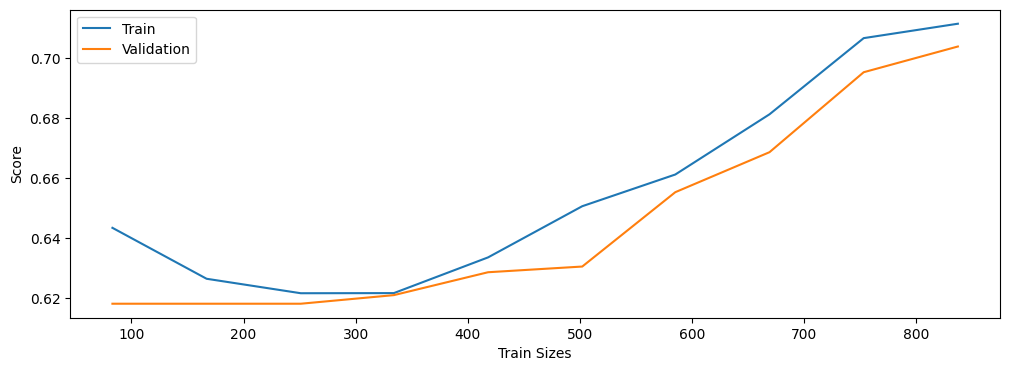

In [ ]:
# Plotting learning curve to determine the optimal training data size
trainsizes, train_score, val_score = learning_curve(titanic_pipe_bestmodel, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, num=10),
                                                            cv=KFold(n_splits=n_lots, shuffle=True, random_state=rng))
mean_train_score, mean_val_score = train_score.mean(axis=1), val_score.mean(axis=1)

# Figure for plotting train_score and validation_score
plt.figure(figsize=(12,4))
plt.subplot(1, 1, 1)
# Plotting mean train score and mean val score depending on the parameter testing
plt.plot(trainsizes, mean_train_score, label='Train')
plt.plot(trainsizes, mean_val_score, label='Validation')
plt.legend()
plt.xlabel('Train Sizes')
plt.ylabel('Score')
plt.show()

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**

In [ ]:
#train roc-auc: 0.8450386398763523
#train accuracy: 0.7220630372492837

#test roc-auc: 0.8354629629629629
#test accuracy: 0.7137404580152672
